In [1]:
# important, you need to install scvelo

import os
import numpy as np
import pandas as pd
import scprep
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
import magic
from scipy.stats import spearmanr

In [2]:
path_cwd=os.getcwd()
path_train_data=path_cwd + '/ML4G_Project_2_Data/train_data'
path_test_data=path_cwd + '/ML4G_Project_2_Data/test_data'

In [3]:
#train_data
bulk_train=pd.read_csv(path_train_data +'/pancreas_bulk_train.csv',index_col=0)
metadata_train=pd.read_csv(path_train_data+ '/pancreas_sc_metadata_train.csv')
metadata_train["Celltype_Int"] = pd.factorize(metadata_train["Celltype"])[0]
metadata_train["Disease_Int"] = pd.factorize(metadata_train["Disease"])[0]
metadata_train["Sample_Int"] = pd.factorize(metadata_train["Sample"])[0]
sc_train=scprep.io.load_csv(path_train_data +'/pancreas_sc_train.csv', cell_axis='column')

#test_data
metadata_test=pd.read_csv(path_test_data+ '/pancreas_sc_metadata_test_wocelltype.csv')
metadata_test["Disease_Int"] = pd.factorize(metadata_test["Disease"])[0]
metadata_test["Sample_Int"] = pd.factorize(metadata_test["Sample"])[0]
sc_test=scprep.io.load_csv(path_test_data +'/pancreas_sc_test.csv', cell_axis='column')

## 0. Preprocessing Methods

In [6]:
# Preprocessing
def sc_preprocess(sc_data, min_cells=0, sq_transform=True, normalize=True):
    # filter out genes with low expression
    sc_data = scprep.filter.filter_rare_genes(sc_data, min_cells=min_cells)

    # Normalize library sizes
    if normalize==True:
        sc_data = scprep.normalize.library_size_normalize(sc_data)
        
    # Transform sqrt
    if sq_transform==True:
        sc_data = scprep.transform.sqrt(sc_data)

    return sc_data

## 1. Data Imputation

In [7]:
# Preprocess the data
sc_train_pp = sc_preprocess(sc_train, min_cells=200) # without sc_filter!
sc_test_pp = sc_preprocess(sc_test, min_cells=200) 
sc_train_pp.head(3)

Unnamed: 0,CLIC4,NECAP2,DBT,RFWD2,C1orf21,PRUNE,PRKCZ,PRDM16,C1orf159,CAMTA1,...,TYMP,NCAPH2,SBF1,LMF2,ODF3B,ARSA,MAPK8IP2,CHKB,RABL2B,RPL23AP82
patient1_A10,1.162871,1.220938,0.103188,1.047245,1.686107,0.000000,0.309564,0.0,1.011033,0.956927,...,0.37205,0.00000,0.000000,0.869478,1.125649,0.000000,0.000000,0.472867,0.000000,0.0
patient1_A12,0.000000,0.000000,0.731252,0.000000,0.000000,1.500498,0.000000,0.0,0.000000,0.589156,...,0.00000,1.09152,0.000000,0.000000,0.556399,1.900466,0.780884,0.256259,0.000000,0.0
patient1_A13,0.000000,0.000000,0.920342,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.00000,0.00000,0.426036,0.000000,0.000000,1.307358,1.496188,0.388916,0.639053,0.0


In [16]:
# MAGIC
sc_train_magic = magic.MAGIC(n_pca=10,
                              t='auto',
                                knn=30,
                                decay=5,
                                n_jobs=1,
                                random_state=0,
                                verbose=2
                              ).fit_transform(sc_train_pp.iloc[:100,:1000])
sc_train_magic.head(3)
#sc_train_magic.to_csv('ML4G_Project_2_Data/imputed_data/imputed_data_magic_pp.csv')

Calculating MAGIC...
  Running MAGIC on 100 cells and 1000 genes.
  Calculating graph and diffusion operator...
    Building knn graph
    Initializing [<class 'graphtools.graphs.kNNGraph'>] with arguments anisotropy='0', bandwidth='None', random_state='0', n_jobs='1', decay='5', verbose='2', initialize='True', bandwidth_scale='1.0', kernel_symm='+', knn='30', distance='euclidean', thresh='0.0001', rank_threshold='None', theta='None', knn_max='90', n_pca='10'
    Calculating PCA...
    Calculated PCA in 0.01 seconds.
    Initializing kernel...
    Calculating KNN search...
    Calculating affinities...
      search_knn = 91; 11 remaining
      knn search to knn_max (91) on 11
    Calculated affinities in 0.02 seconds.
    Using addition symmetrization.
  Calculated graph and diffusion operator in 0.07 seconds.
  Calculating imputation...
    1: [0.7449078875085332]
    2: [0.7449078875085332, 0.13972928416062297]
    3: [0.7449078875085332, 0.13972928416062297, 0.03419494340055004]
   

Unnamed: 0,CLIC4,NECAP2,DBT,RFWD2,C1orf21,PRUNE,PRKCZ,PRDM16,C1orf159,CAMTA1,...,NVL,WDR26,CNIH4,LBR,EPHX1,TMEM63A,SDE2,PYCR2,H3F3A,PARP1
patient1_A10,0.176162,0.297228,0.251817,0.139637,0.286725,0.843611,0.080760,0.064377,0.110024,0.834761,...,0.178003,0.404396,0.645143,0.253062,0.277799,0.014222,0.188808,0.593245,0.17938,0.869517
patient1_A12,0.176285,0.295589,0.250554,0.139375,0.288783,0.847296,0.080351,0.064571,0.110341,0.835340,...,0.178419,0.403665,0.645107,0.251823,0.280878,0.014241,0.188772,0.593849,0.17943,0.867256
patient1_A13,0.175939,0.299355,0.253391,0.140063,0.284168,0.838732,0.081328,0.064103,0.109641,0.833969,...,0.177452,0.405261,0.645197,0.254633,0.273694,0.014182,0.188883,0.592124,0.17932,0.872097


In [223]:
# MAGIC
sc_train_magic = magic.MAGIC(n_pca=1000,
                              t='auto',
                                knn=50,
                                decay=1,
                                n_jobs=8,
                                random_state=0,
                                verbose=2
                              ).fit_transform(sc_test_pp)
sc_train_magic.head(3)
sc_train_magic.to_csv('ML4G_Project_2_Data/imputed_data/imputed_test_data_magic_pp.csv')

Set graphtools logging to DEBUG
Calculating MAGIC...
  Running MAGIC on 789 cells and 10349 genes.
  Calculating graph and diffusion operator...
    Building knn graph
    Initializing [<class 'graphtools.graphs.kNNGraph'>] with arguments kernel_symm='+', decay='1', thresh='0.0001', n_pca='1000', rank_threshold='None', bandwidth_scale='1.0', verbose='2', theta='None', distance='euclidean', anisotropy='0', knn='50', n_jobs='8', random_state='0', initialize='True', bandwidth='None', knn_max='150'
    Initializing kernel...
    Calculating KNN search...
    Calculated KNN search in 1.74 seconds.
    Calculating affinities...
      search_knn = 151; 789 remaining
      knn search to knn_max (151) on 789
    Calculated affinities in 1.74 seconds.
    Using addition symmetrization.
  Calculated graph and diffusion operator in 3.50 seconds.
  Running MAGIC with `solver='exact'` on 10349-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using 

In [54]:
# remove list of elements from a list
filtered_genes = [gene for gene in sc_train.columns if gene not in sc_train_magic.columns]
filtered_genes_df = pd.DataFrame(0, index=filtered_genes, columns=['genes'])

In [55]:
# add filtered genes to magic dataframe
pred = sc_train_magic.mean(axis=0)
pred = pd.DataFrame(pred, columns=['genes'])
pred_all = pd.concat([pred, filtered_genes_df], axis=0)
pred_all = pred_all.reindex(sc_train.columns)

In [41]:
# check correlation
baseline=spearmanr(sc_train.mean(axis=0),bulk_train.mean(axis=1)).statistic
score=spearmanr(pred_all,bulk_train.mean(axis=1)).statistic
print(f'Correlation before imputation: {baseline}')
print(f'Best Correlation: {score}')

NameError: name 'pred_all' is not defined

## 2. Clustering - Batch Correction

In [28]:
# Load data
import harmonypy as hm

def perform_batch_correction(meta_data, data, vars_use, max_iter = 20):
    """
    Perform batch correction on data to eliminate effects of patient number and health status.
    """
    # Create data matrix
    data_mat = np.array(data)

    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use, max_iter_harmony=max_iter)

    # Format output
    data_bc = pd.DataFrame(ho.Z_corr).T
    data_bc.index = data.index
    data_bc.columns = ['X{}'.format(i + 1) for i in range(data.shape[1])]

    return data_bc
    
# Apply function
meta_data = metadata_train
data = sc_train_pp 
vars_use = ['Disease', 'Sample']

sc_train_pp_bc = perform_batch_correction(meta_data, data, vars_use)
# sc_train_pp_bc.to_csv("ML4G_Project_2_Data/train_data/pancreas_sc_train_pp_bc_sample_disease.csv")

2023-04-24 17:19:54,716 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-24 17:19:58,389 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-24 17:19:58,400 - harmonypy - INFO - Iteration 1 of 20
2023-04-24 17:20:00,333 - harmonypy - INFO - Iteration 2 of 20
2023-04-24 17:20:02,046 - harmonypy - INFO - Iteration 3 of 20
2023-04-24 17:20:03,948 - harmonypy - INFO - Iteration 4 of 20
2023-04-24 17:20:05,837 - harmonypy - INFO - Iteration 5 of 20
2023-04-24 17:20:07,703 - harmonypy - INFO - Converged after 5 iterations


## 2. Clustering - UMAP Visualizations

In [11]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

<Axes: >

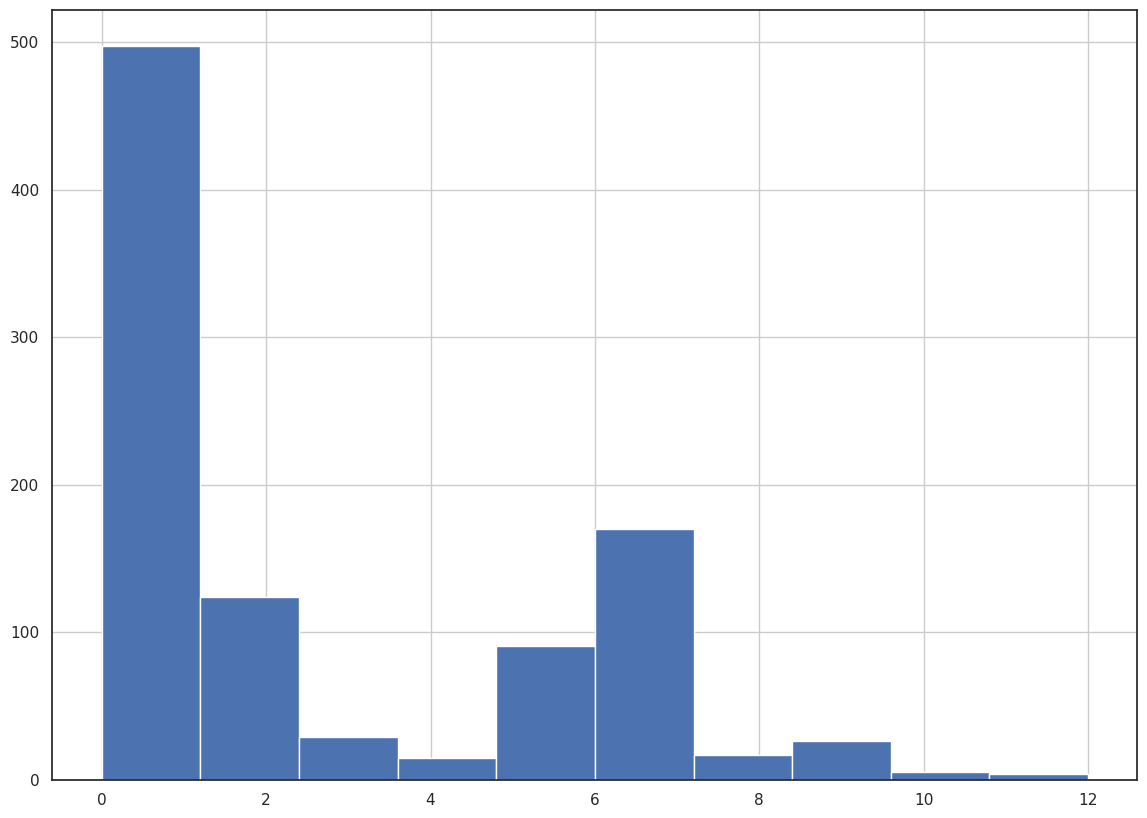

In [ ]:
# Show number of celltypes in training data
metadata_train["Celltype"].hist()

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not 0             acinar cell
1              alpha cell
2              gamma cell
3              gamma cell
4              gamma cell
              ...        
973    co-expression cell
974            alpha cell
975            alpha cell
976            alpha cell
977            alpha cell
Name: Celltype, Length: 978, dtype: object

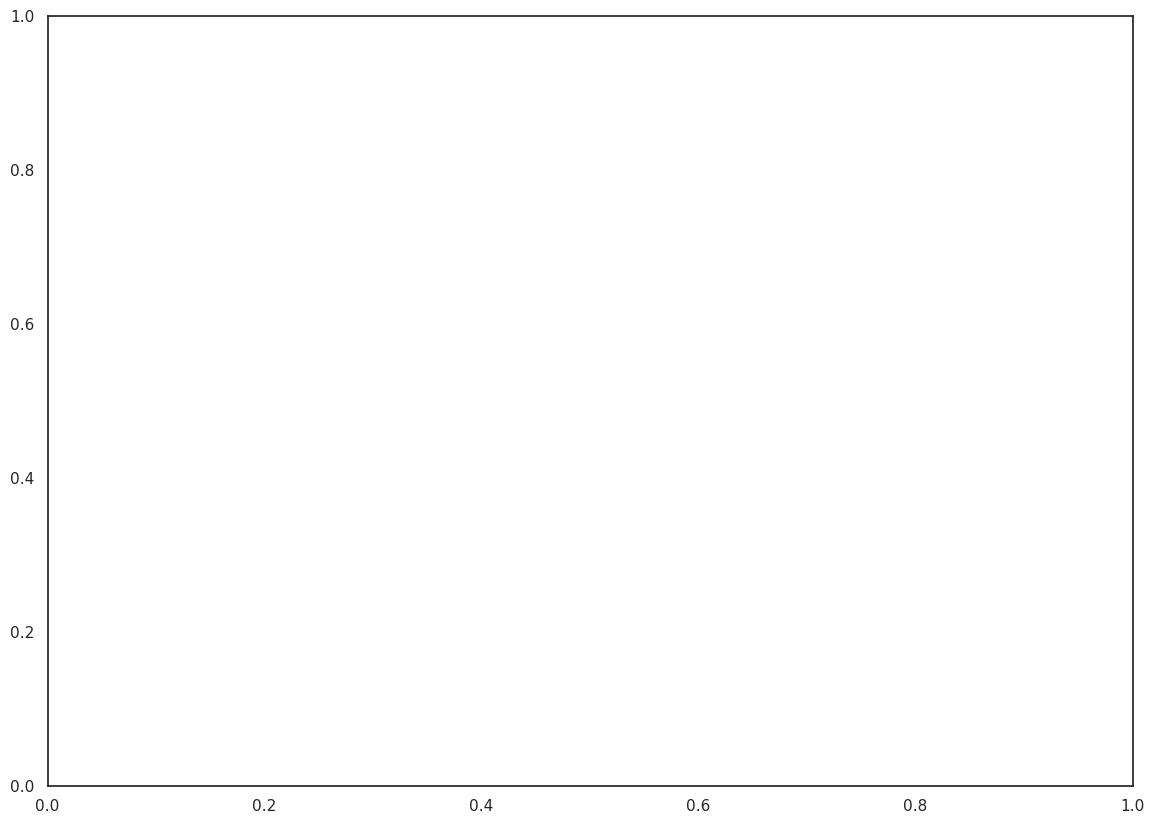

In [18]:
# Imputed data MAGIC - preprocessed
imputed_data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_magic_pp.csv", index_col=0)
standard_embedding = umap.UMAP(random_state=42).fit_transform(imputed_data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

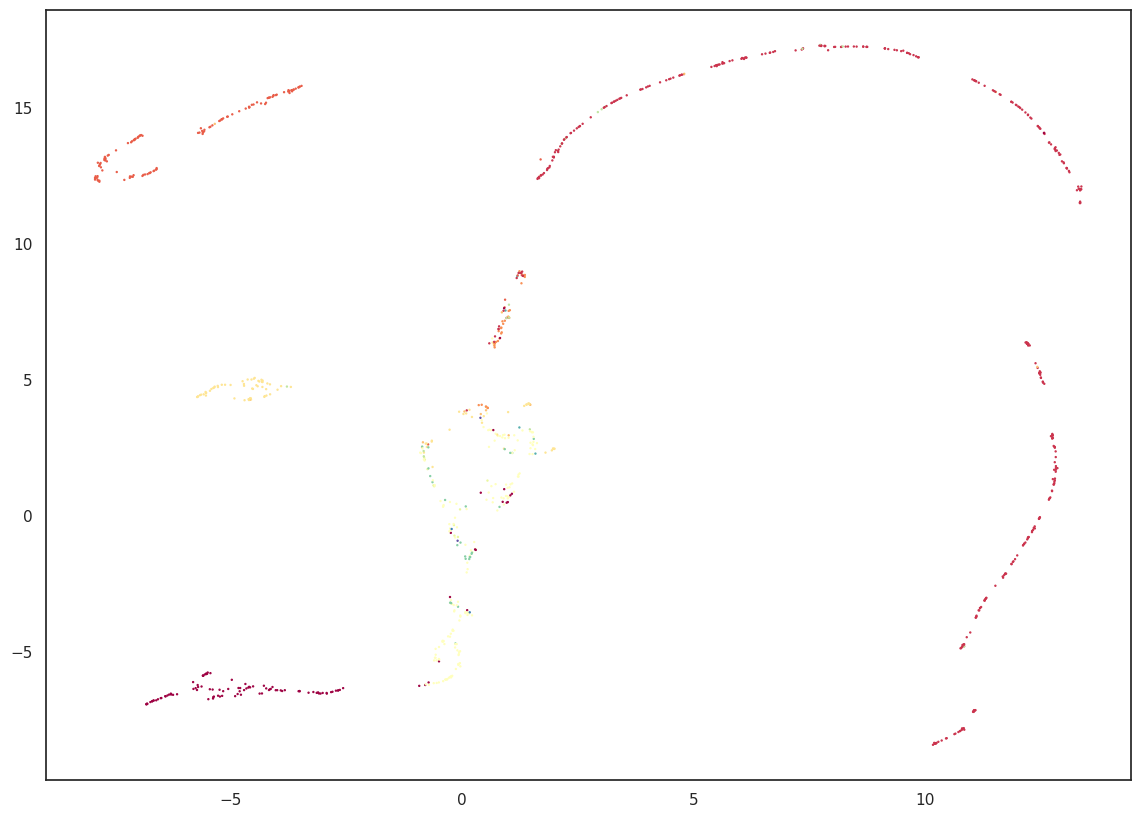

In [61]:
# Imputed data MAGIC
imputed_data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_magic.csv", index_col=0)
standard_embedding = umap.UMAP(random_state=42).fit_transform(imputed_data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

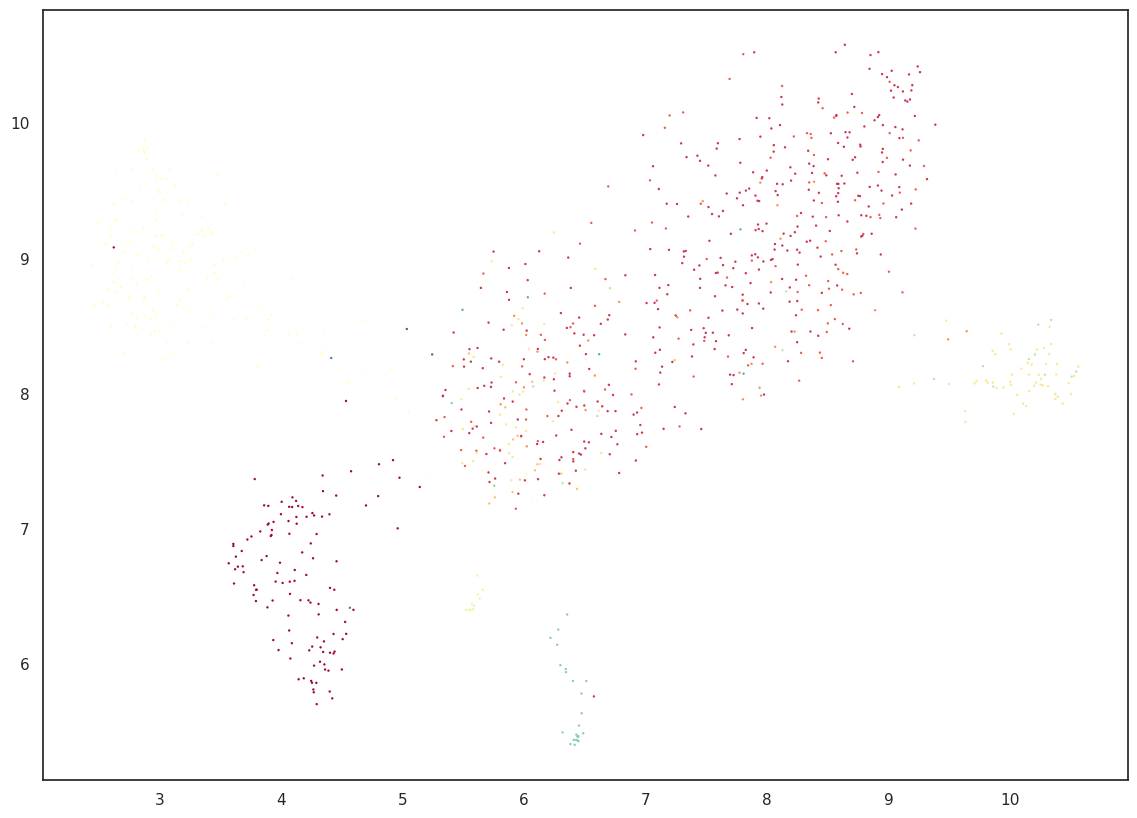

In [89]:
# Imputed data scISR
imputed_data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_scISR_pp.csv", index_col=0)
imputed_data = sc_preprocess(imputed_data, min_cells=200)
standard_embedding = umap.UMAP(random_state=42).fit_transform(imputed_data.T)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

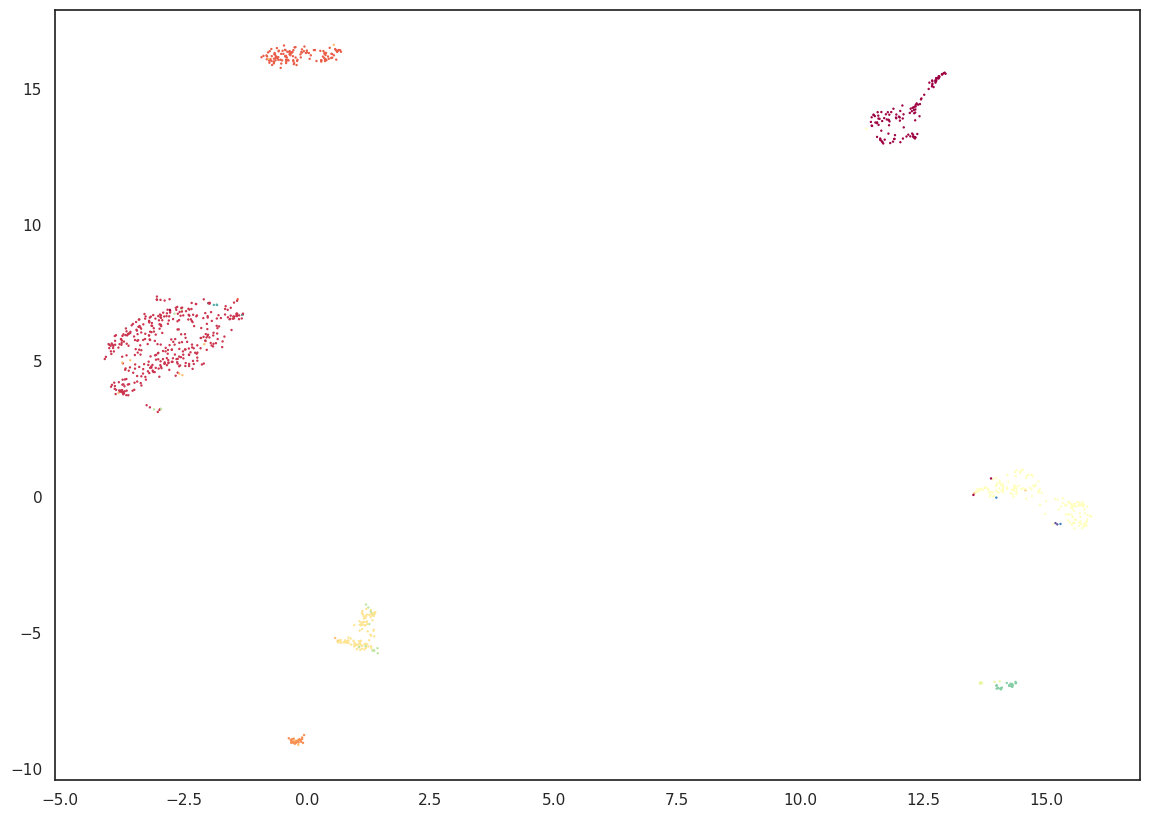

In [149]:
# With preprocessing raw data
sc_train_pp = sc_preprocess(sc_train, 200)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

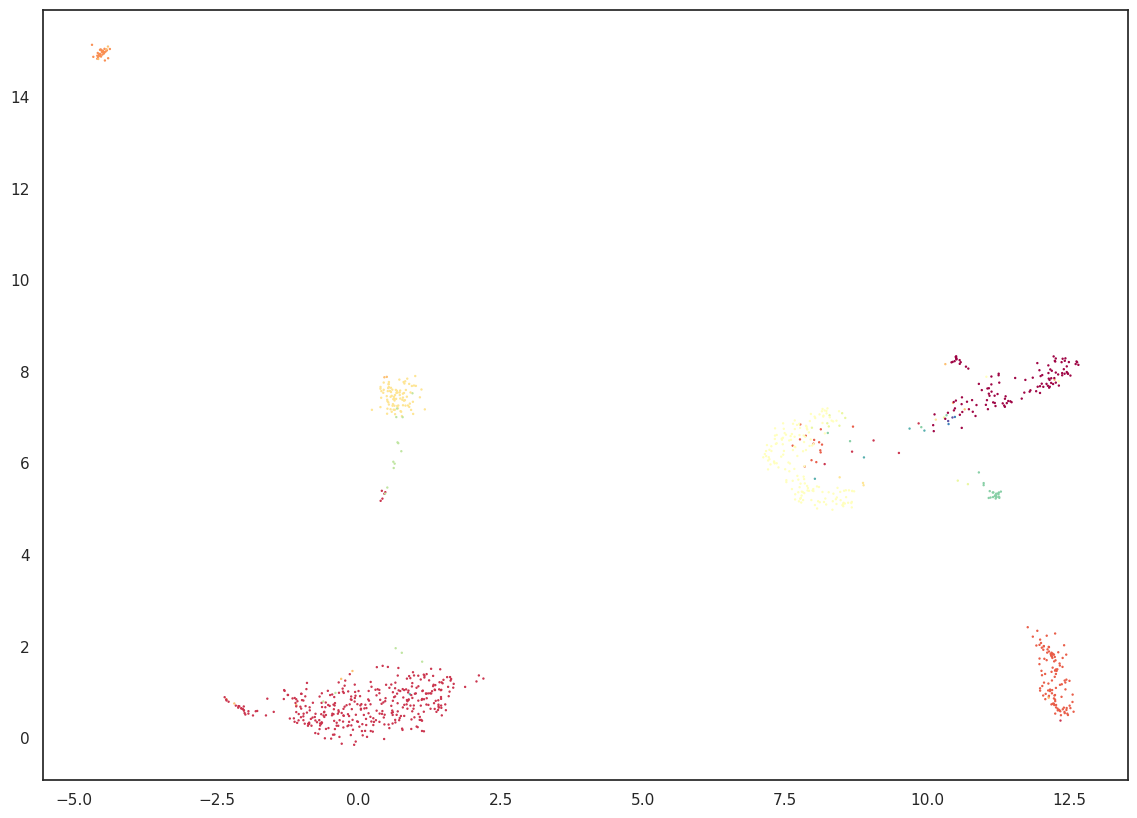

In [96]:
# With precpressed and batch corrected raw data
sc_train_pp_bc = pd.read_csv("ML4G_Project_2_Data/train_data/pancreas_sc_train_pp_bc_sample_disease.csv", index_col=0)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp_bc)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

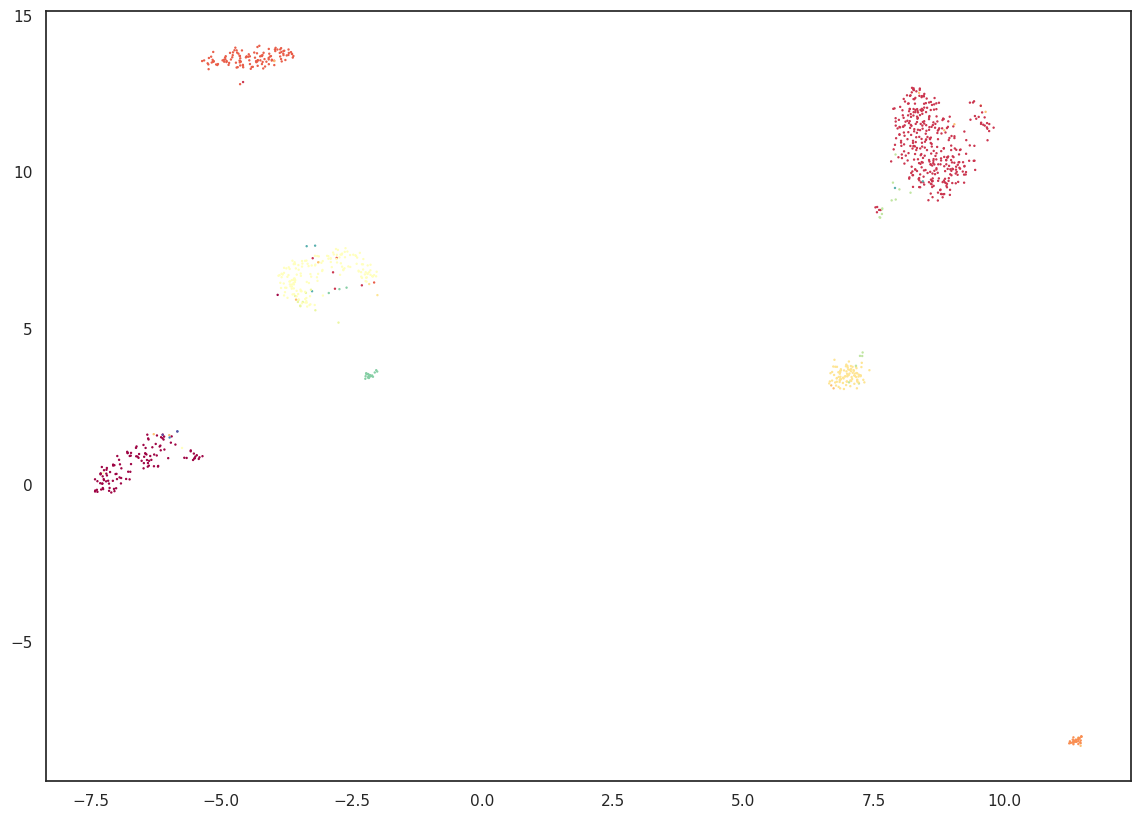

In [97]:
# With precpressed and batch corrected (only on disease) raw data
sc_train_pp_bc = pd.read_csv("ML4G_Project_2_Data/train_data/pancreas_sc_train_pp_bc_disease.csv", index_col=0)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp_bc)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

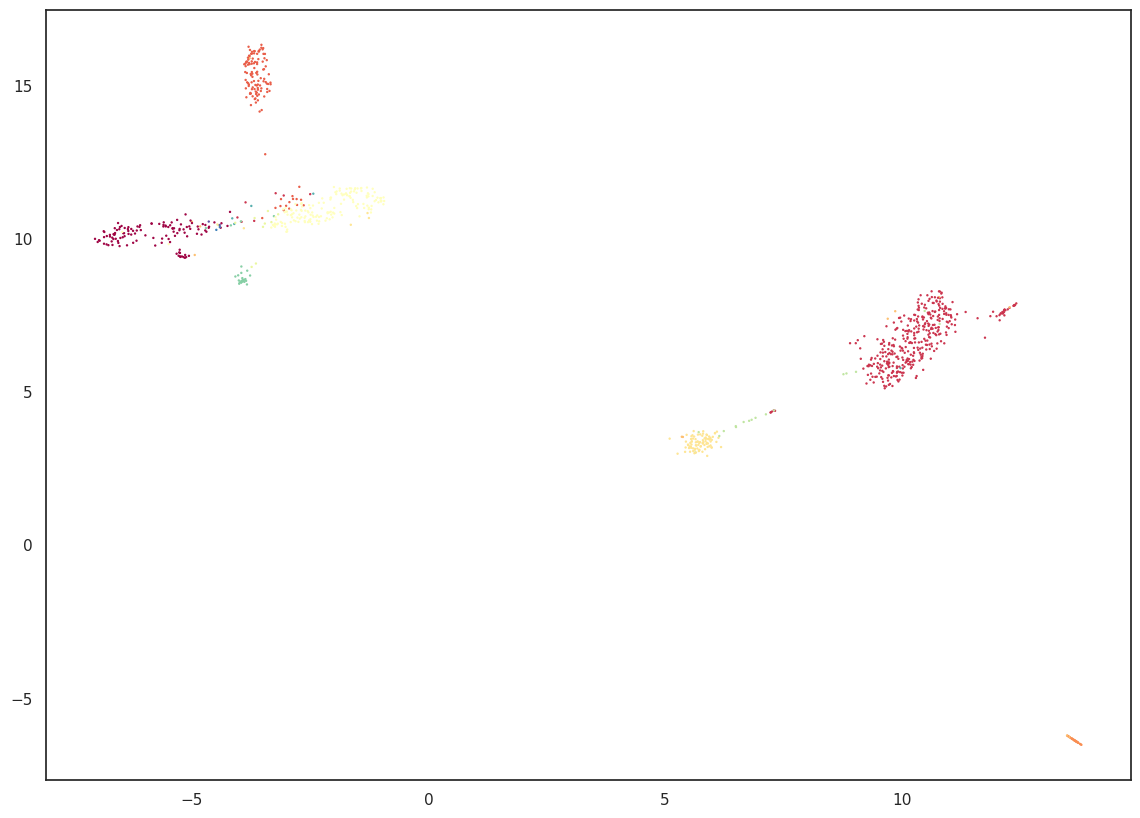

In [98]:
# With precpressed and batch corrected (only on sample) raw data
sc_train_pp_bc = pd.read_csv("ML4G_Project_2_Data/train_data/pancreas_sc_train_pp_bc_sample.csv", index_col=0)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp_bc)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

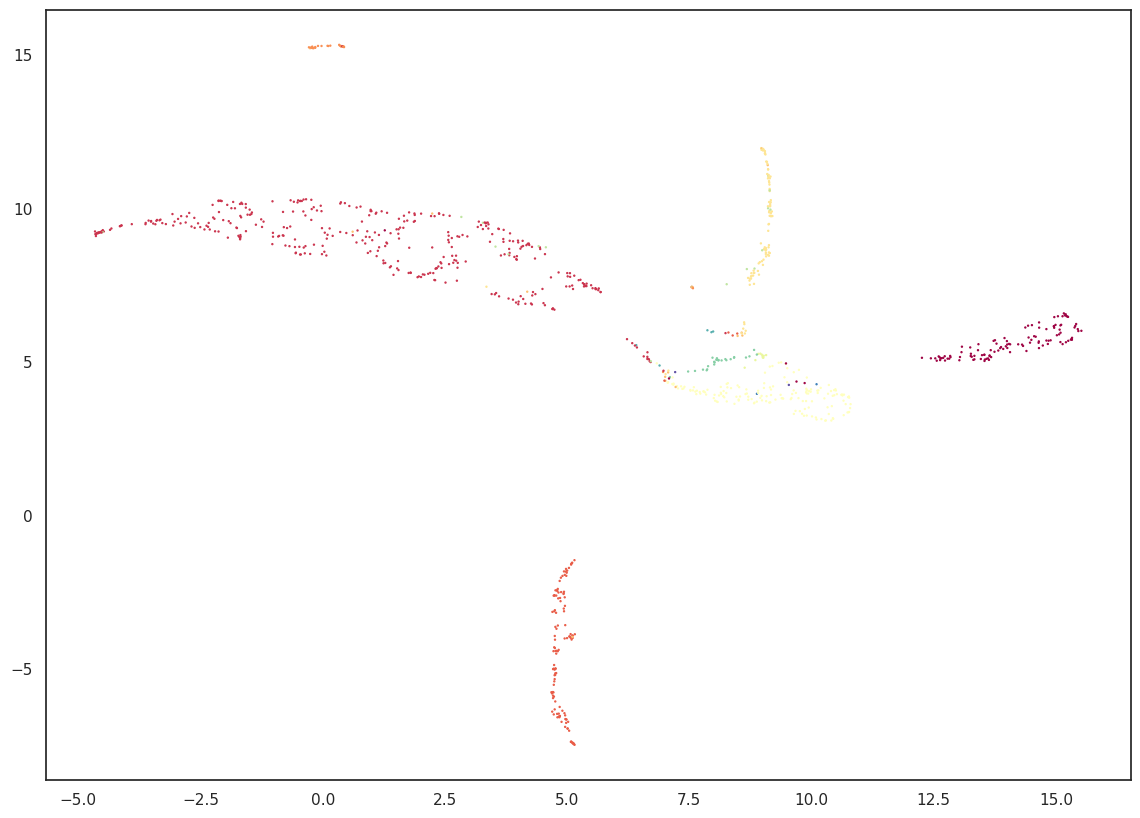

In [150]:
# With preprocessing raw data and without normalization or sqrt transformation
sc_train_pp = sc_preprocess(sc_train, 200, normalize=False, sq_transform=False)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

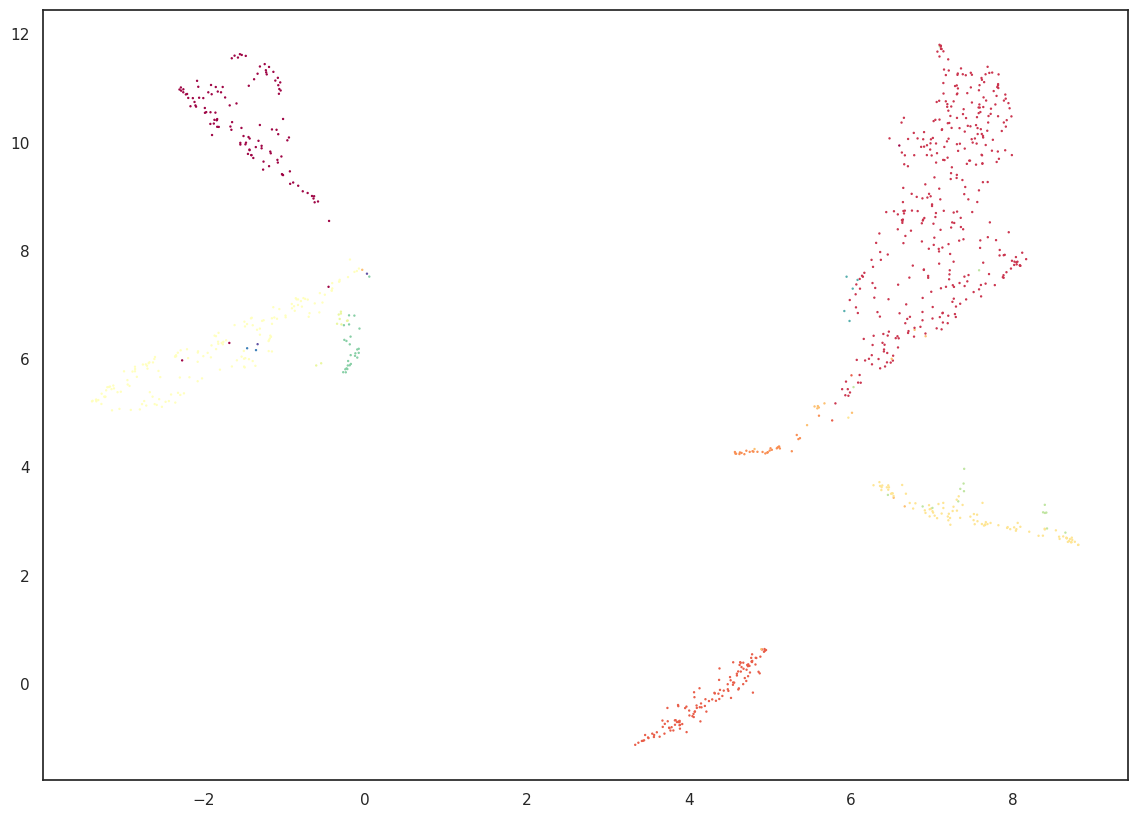

In [152]:
# With preprocessing raw data and without sqrt transformation
sc_train_pp = sc_preprocess(sc_train, 200, normalize=False, sq_transform=True)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.5, cmap='Spectral');

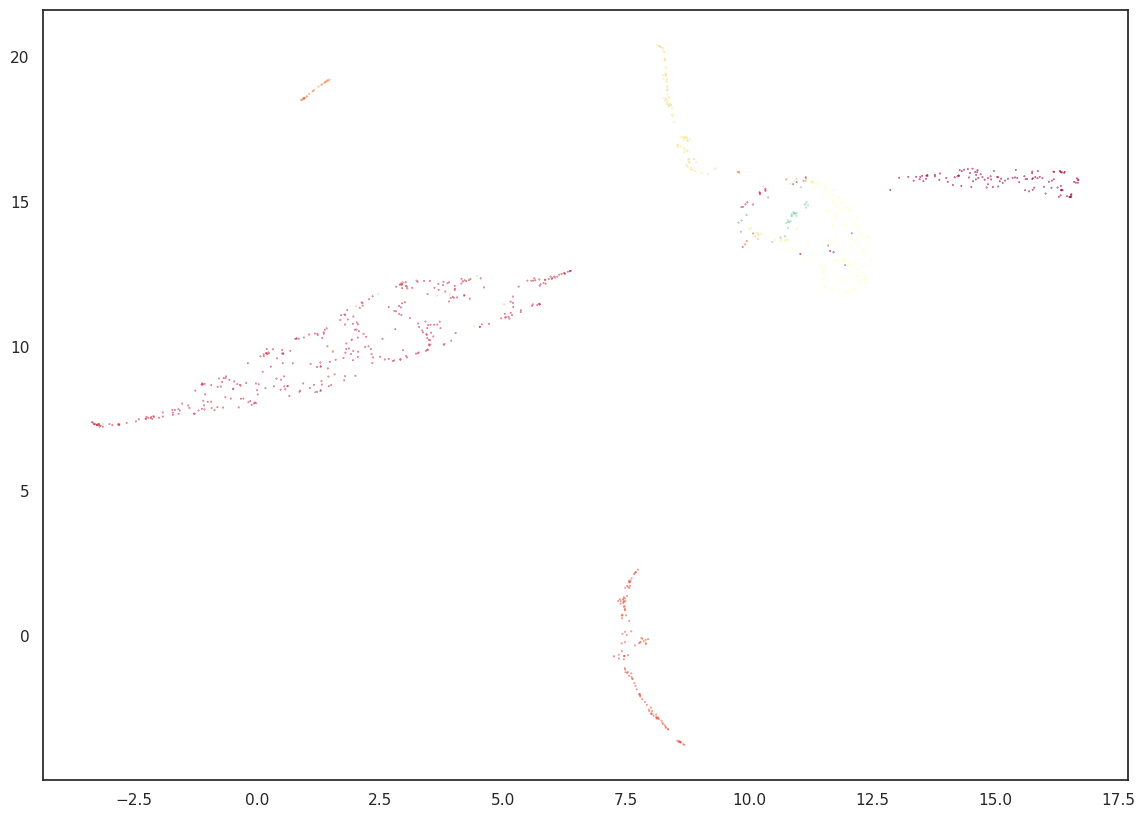

In [33]:
# Without preprocessing raw data
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_train["Celltype_Int"], s=0.1, cmap='Spectral',);

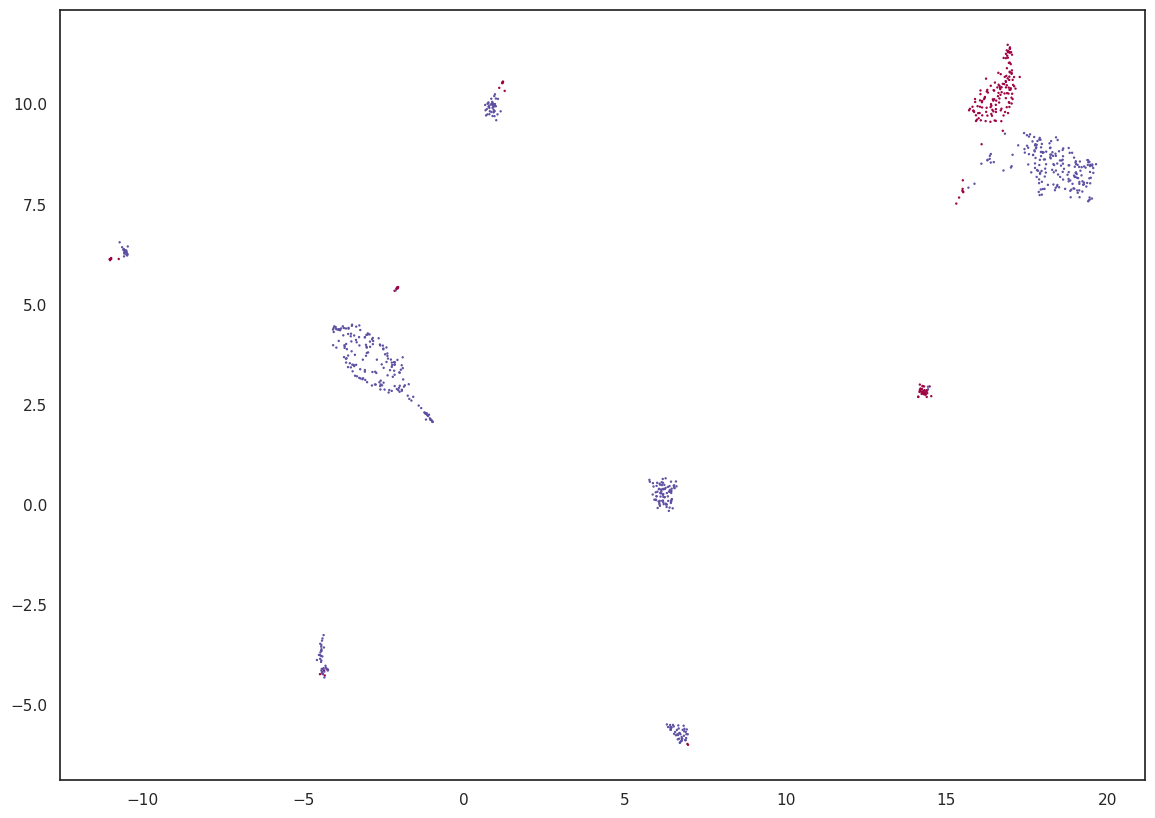

In [102]:
# Try on test data
sc_test_pp = sc_preprocess(sc_test, 200)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_test_pp)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_test["Disease_Int"], s=0.5, cmap='Spectral');

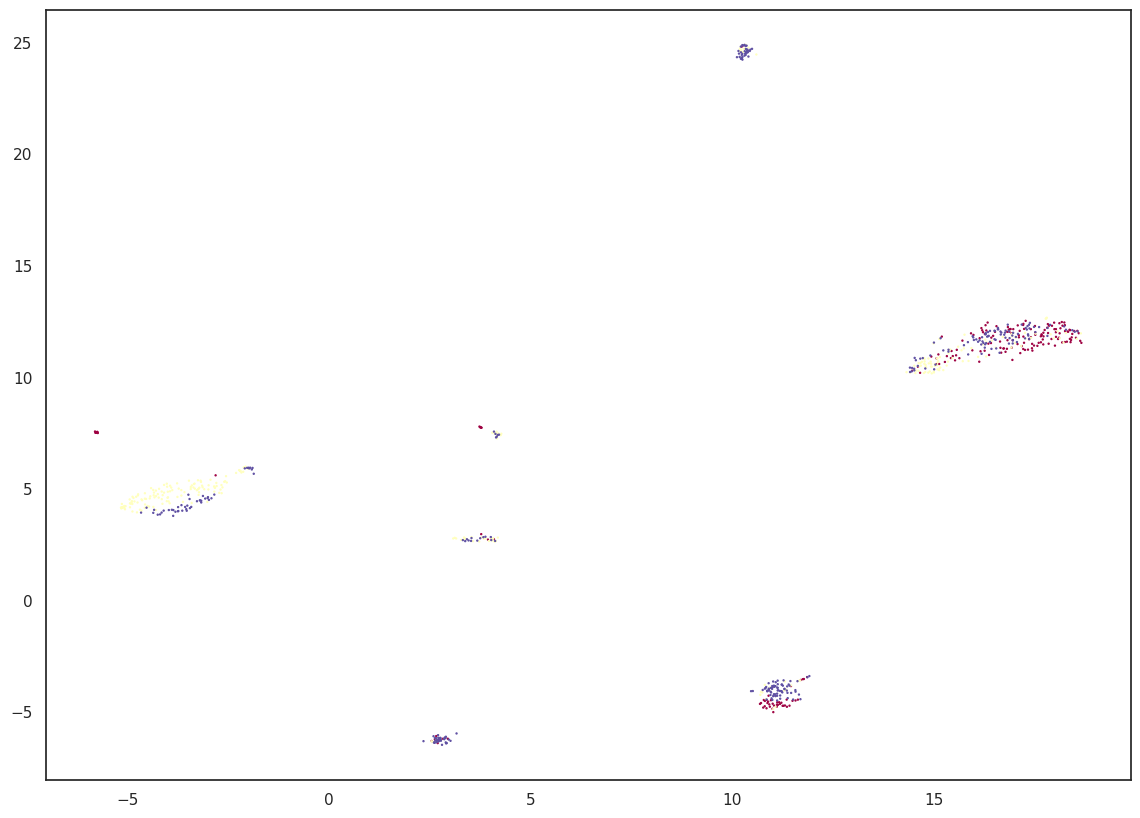

In [23]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_test["Sample_Int"], s=0.5, cmap='Spectral');

2023-04-22 22:20:06,559 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-22 22:20:08,981 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-22 22:20:08,989 - harmonypy - INFO - Iteration 1 of 20
2023-04-22 22:20:10,198 - harmonypy - INFO - Iteration 2 of 20
2023-04-22 22:20:11,441 - harmonypy - INFO - Iteration 3 of 20
2023-04-22 22:20:12,501 - harmonypy - INFO - Iteration 4 of 20
2023-04-22 22:20:13,527 - harmonypy - INFO - Iteration 5 of 20
2023-04-22 22:20:14,405 - harmonypy - INFO - Iteration 6 of 20
2023-04-22 22:20:15,332 - harmonypy - INFO - Iteration 7 of 20
2023-04-22 22:20:16,221 - harmonypy - INFO - Iteration 8 of 20
2023-04-22 22:20:17,167 - harmonypy - INFO - Iteration 9 of 20
2023-04-22 22:20:18,042 - harmonypy - INFO - Iteration 10 of 20
2023-04-22 22:20:18,936 - harmonypy - INFO - Iteration 11 of 20
2023-04-22 22:20:19,800 - harmonypy - INFO - Iteration 12 of 20
2023-04-22 22:20:20,667 - harmonypy - INFO - Iteration 13 of

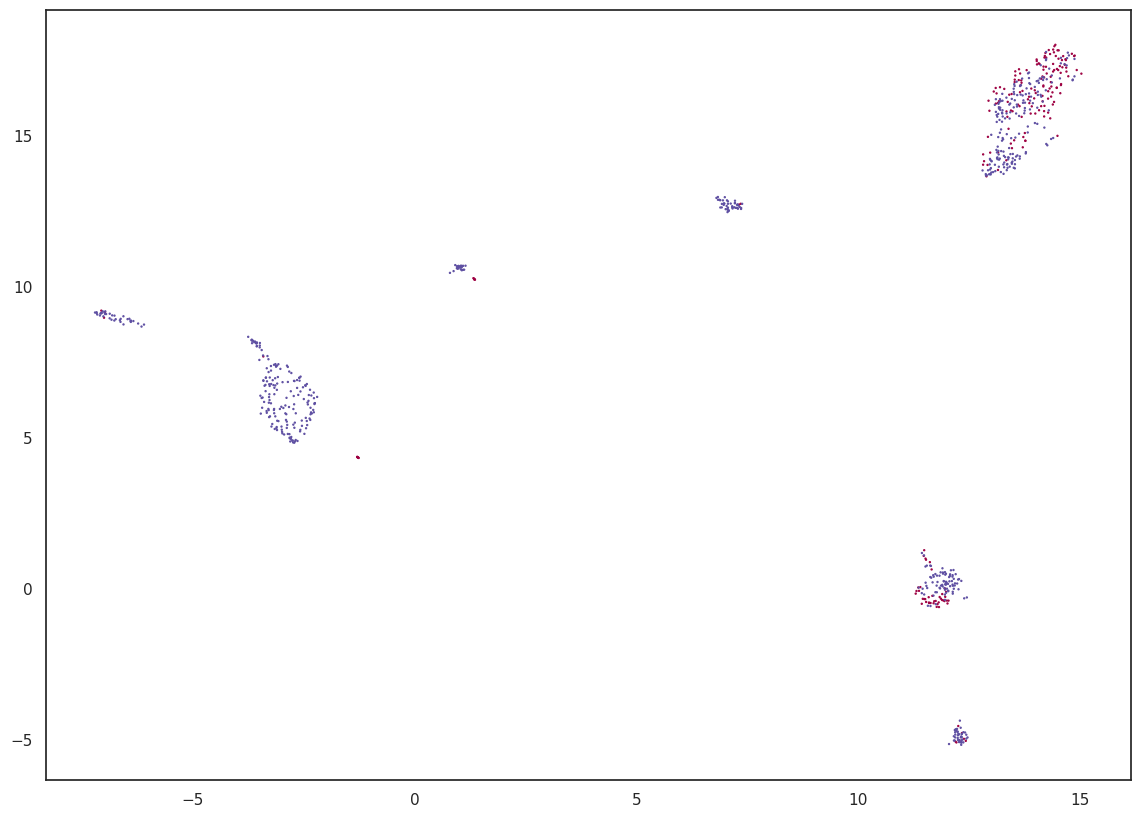

In [29]:
# Try on test data with batch correction
sc_test_pp = sc_preprocess(sc_test, 200)
use_vars = ["Disease"]
sc_test_bc = perform_batch_correction(metadata_test, sc_test_pp, use_vars)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_test_bc)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_test["Disease_Int"], s=0.5, cmap='Spectral');

2023-04-22 22:18:34,455 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-22 22:18:36,942 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-22 22:18:36,950 - harmonypy - INFO - Iteration 1 of 20
2023-04-22 22:18:38,016 - harmonypy - INFO - Iteration 2 of 20
2023-04-22 22:18:39,159 - harmonypy - INFO - Iteration 3 of 20
2023-04-22 22:18:40,298 - harmonypy - INFO - Iteration 4 of 20
2023-04-22 22:18:41,446 - harmonypy - INFO - Iteration 5 of 20
2023-04-22 22:18:42,536 - harmonypy - INFO - Iteration 6 of 20
2023-04-22 22:18:43,768 - harmonypy - INFO - Iteration 7 of 20
2023-04-22 22:18:44,886 - harmonypy - INFO - Iteration 8 of 20
2023-04-22 22:18:46,020 - harmonypy - INFO - Iteration 9 of 20
2023-04-22 22:18:46,919 - harmonypy - INFO - Iteration 10 of 20
2023-04-22 22:18:47,811 - harmonypy - INFO - Iteration 11 of 20
2023-04-22 22:18:48,708 - harmonypy - INFO - Iteration 12 of 20
2023-04-22 22:18:49,574 - harmonypy - INFO - Iteration 13 of

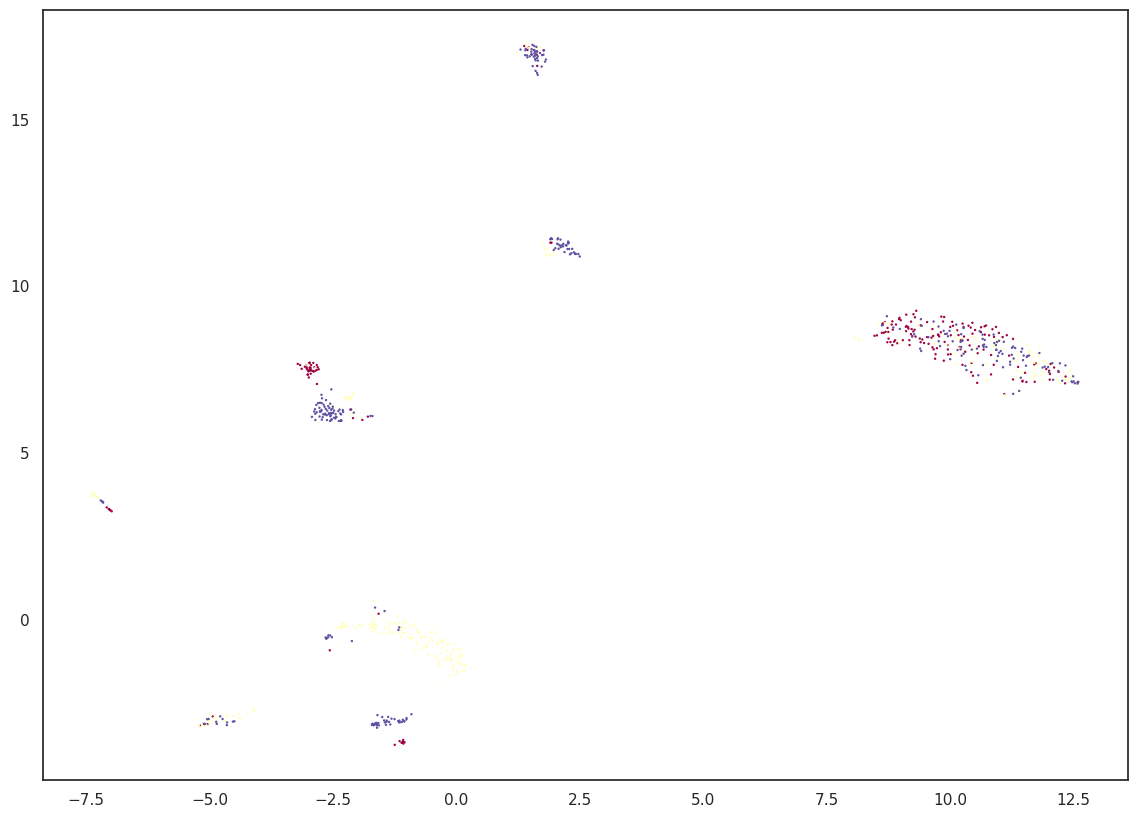

In [27]:
# Try on test data with batch correction
sc_test_pp = sc_preprocess(sc_test, 200)
use_vars = ["Sample", "Disease"]
sc_test_bc = perform_batch_correction(metadata_test, sc_test_pp, use_vars, max_iter=20)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_test_bc)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=metadata_test["Sample_Int"], s=0.5, cmap='Spectral');

## 2. Clustering - PCA

In [12]:
import numpy as np
from sklearn.decomposition import PCA

In [13]:
def compute_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    pca.fit(data.T)
    return pca

def store_pca(pca, data, path):
    pca_df = pd.DataFrame(pca.components_.T, columns=["PC"+str(i) for i in range(1,51)])
    pca_df.insert(0, "index", data.index)
    pca_df.to_csv(path, index=True)

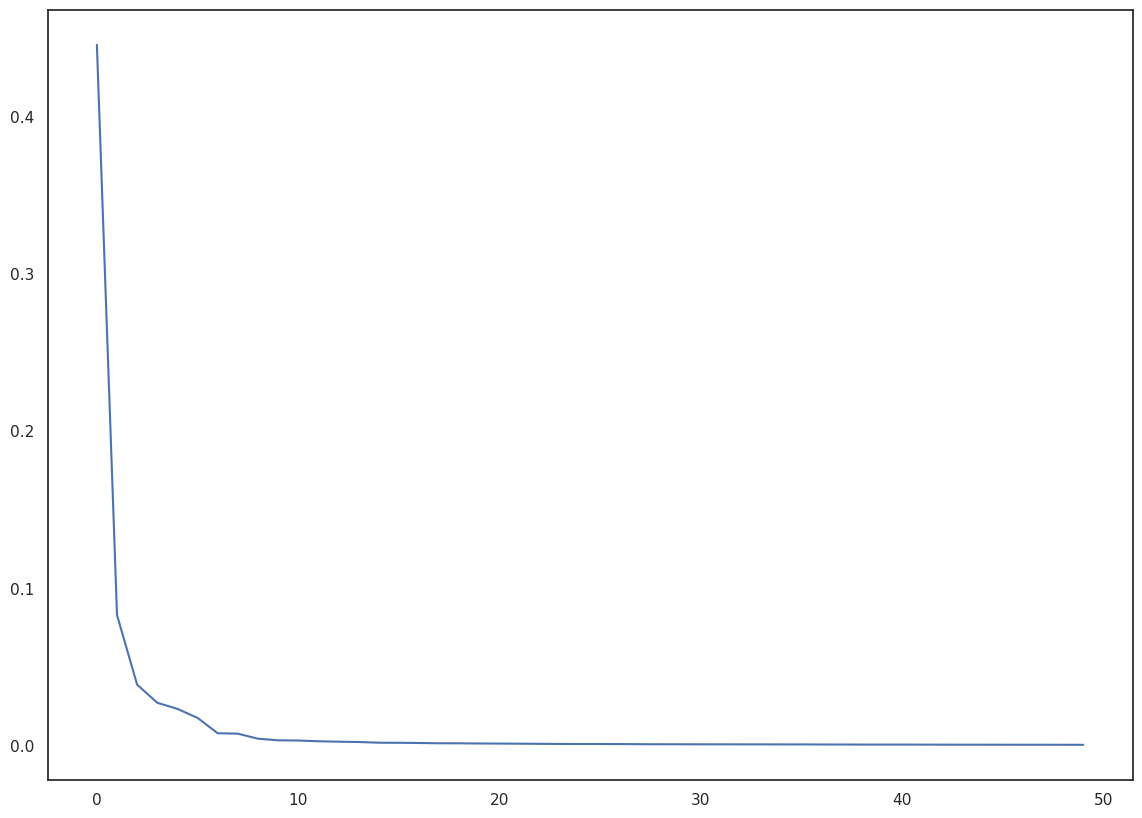

In [203]:
# Example
sc_train_pp_bc = pd.read_csv("ML4G_Project_2_Data/train_data/pancreas_sc_train_pp_bc_disease.csv", index_col=0)
pca = compute_pca(sc_train_pp_bc, 50)

# plot explained variance
plt.plot(pca.explained_variance_ratio_)

# Store PCA components in correct format
store_pca(pca, sc_train_pp, "ML4G_Project_2_Data/pca/PCA_train_pp_bc_disease.csv")

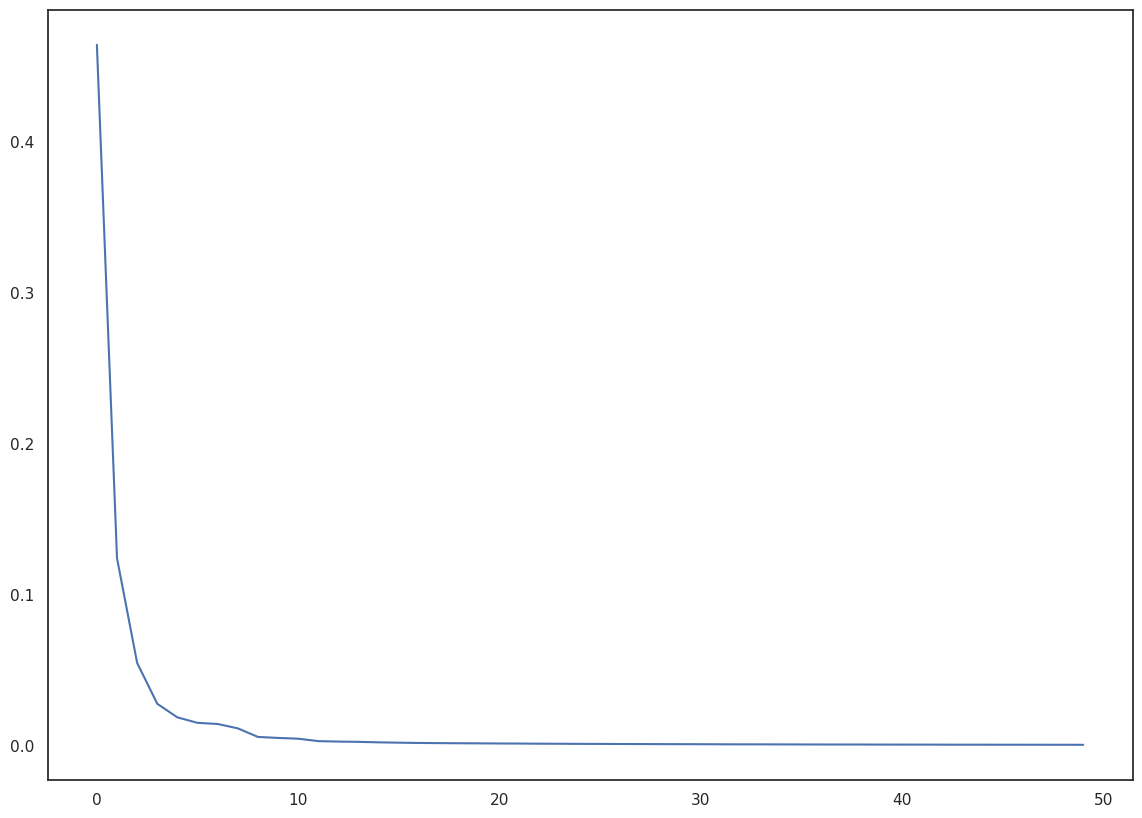

In [137]:
# compute PCA on test data
pca = PCA(n_components=50)
sc_test_pp = sc_preprocess(sc_test, 200)
pca.fit(sc_test_pp.T)

# plot explained variance
plt.plot(pca.explained_variance_ratio_)

# Store PCA components in correct format
pca_df = pd.DataFrame(pca.components_.T, columns=["PC"+str(i) for i in range(1,51)])
pca_df.insert(0, "index", sc_test_pp.index)
pca_df.to_csv("ML4G_Project_2_Data/pca/PCA.csv",index=True)

## 2. Clustering - Evaluation Metrics

In [14]:

from sklearn import metrics
def print_scores(pca_matrix, labels, labels_true):
    """
    Print various scores
    """
    #print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
    #print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
    v_score = metrics.v_measure_score(labels_true, labels)
    ari_score = metrics.adjusted_rand_score(labels_true, labels)
    silhouette_score = metrics.silhouette_score(pca_matrix, labels)

    print(f"V-measure: {v_score:.3f}")
    print(f"Adjusted Rand Index: {ari_score:.3f}")
    #print(
    #     "Adjusted Mutual Information:"
    #     f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
    # )
    print(f"Silhouette Coefficient: {silhouette_score:.3f}")
    print(f"Overall Clustering Score: {1/3*(v_score+ari_score+silhouette_score)}")

def get_clustering_score(pca_matrix, labels, labels_true):
    """
    Return clustering score
    """
    v_score = metrics.v_measure_score(labels_true, labels)
    ari_score = metrics.adjusted_rand_score(labels_true, labels)
    silhouette_score = metrics.silhouette_score(pca_matrix, labels)

    return 1/3*(v_score+ari_score+silhouette_score)

def get_silhouette_score(pca_matrix, labels):
    return metrics.silhouette_score(pca_matrix, labels)

In [15]:
from hdbscan import HDBSCAN
from hdbscan.flat import (HDBSCAN_flat,
                          approximate_predict_flat,
                          membership_vector_flat,
                          all_points_membership_vectors_flat)

def obtain_clusters_HDBSCAN(data, n_components=50, n_clusters=13, min_cluster_size=2):
    """
    Obtain clusters using HDBSCAN with fixed number of clusters
    HDBSCAN is a density-based clustering algorithm that aims to find clusters of varying shapes and 
    densities in high-dimensional data. It works by constructing a hierarchical clustering tree, called 
    a minimum spanning tree, based on the density of the data points. Then, it extracts clusters from the 
    tree using a cluster stability measure called the robust single linkage. This allows HDBSCAN to find 
    clusters of varying sizes and densities, while also being able to identify noise points and outliers.
    """
    lowd_sc_train = PCA(n_components=50).fit_transform(data)
    clusterer = HDBSCAN_flat(lowd_sc_train,
                         cluster_selection_method='eom',
                         n_clusters=n_clusters, min_cluster_size=min_cluster_size)
    labels = clusterer.labels_
    proba = clusterer.probabilities_
    hdbscan_labels = pd.DataFrame(labels, index=data.index, columns=["HDBSCAN"])
    return hdbscan_labels

In [44]:
sc_train_pp

Unnamed: 0,CLIC4,NECAP2,DBT,RFWD2,C1orf21,PRUNE,PRKCZ,PRDM16,C1orf159,CAMTA1,...,TYMP,NCAPH2,SBF1,LMF2,ODF3B,ARSA,MAPK8IP2,CHKB,RABL2B,RPL23AP82
patient1_A10,1.162871,1.220938,0.103188,1.047245,1.686107,0.000000,0.309564,0.000000,1.011033,0.956927,...,0.372050,0.000000,0.000000,0.869478,1.125649,0.000000,0.000000,0.472867,0.000000,0.00000
patient1_A12,0.000000,0.000000,0.731252,0.000000,0.000000,1.500498,0.000000,0.000000,0.000000,0.589156,...,0.000000,1.091520,0.000000,0.000000,0.556399,1.900466,0.780884,0.256259,0.000000,0.00000
patient1_A13,0.000000,0.000000,0.920342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.426036,0.000000,0.000000,1.307358,1.496188,0.388916,0.639053,0.00000
patient1_A15,0.857661,1.952346,1.507852,0.000000,0.000000,0.000000,0.000000,0.000000,0.944254,0.746498,...,0.000000,0.000000,0.472127,1.107236,0.000000,1.310099,0.365708,0.298599,0.000000,0.00000
patient1_A17,0.000000,1.696330,0.000000,0.315001,0.000000,0.000000,1.488635,0.000000,0.000000,0.927337,...,0.000000,0.000000,0.000000,1.260002,0.000000,0.813328,0.749851,0.000000,0.996119,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
patient4_P5,0.000000,0.781226,0.000000,0.000000,0.000000,0.781226,0.000000,0.000000,0.000000,0.781226,...,0.000000,0.000000,0.552410,0.000000,0.000000,0.956803,0.781226,0.000000,0.000000,0.00000
patient4_P6,0.000000,0.458296,0.000000,0.000000,0.458296,0.561296,0.000000,0.000000,0.000000,1.554158,...,0.793792,1.122592,0.857394,0.000000,0.000000,0.793792,1.412564,0.000000,0.561296,0.00000
patient4_P7,0.195806,0.195806,0.195806,0.807329,0.391612,0.634484,0.138456,0.000000,0.000000,1.214945,...,0.000000,0.391612,0.391612,1.054448,0.138456,1.510375,0.499210,0.000000,0.391612,0.00000
patient4_P8,0.000000,0.669473,0.000000,0.490609,0.791608,0.542814,0.523351,0.507244,0.617896,0.899578,...,0.000000,0.128840,0.000000,1.363517,0.535114,1.166698,0.000000,0.370065,0.182208,0.06442


In [47]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def test_kmeans(data, labels_true, n_clusters, plot = True, print_score = True, test = False):
    # Get labels
  
    # Get pcs
    # lowd_data = PCA(n_components=50).fit_transform(data)

    # KMean= KMeans(n_clusters=n_clusters, max_iter=500)
    # KMean.fit(lowd_data)
    # labels = KMean.predict(lowd_data)
    

    # if print_score and not test:
    #     print_scores(lowd_data, labels, metadata_train["Celltype"])

    # if plot:
    #     standard_embedding = umap.UMAP(random_state=42).fit_transform(lowd_data)
    #     plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=0.5, cmap='Spectral');

    # if test == True:
    #     return get_silhouette_score(lowd_data, labels)
    
    # else:
    #     return get_clustering_score(lowd_data, labels, labels_true)

    lowd_data_c = umap.UMAP(random_state=42, n_components = 979).fit_transform(data)
    lowd_data = PCA(n_components=50).fit_transform(lowd_data_c)

    KMean= KMeans(n_clusters=n_clusters, max_iter=500)
    KMean.fit(lowd_data_c)
    labels = KMean.predict(lowd_data_c)
    

    if print_score and not test:
        print_scores(lowd_data, labels, metadata_train["Celltype"])

    if plot:
        standard_embedding = umap.UMAP(random_state=42).fit_transform(data)
        plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=0.5, cmap='Spectral');

    if test == True:
        return get_silhouette_score(lowd_data, labels)
    
    else:
        return get_clustering_score(lowd_data, labels, labels_true)

def test_kmeans_umap(data, labels_true, n_clusters, n_components, plot = True, print_score = True, test = False):
    # Get labels
  
    # Get pcs
    pca = PCA(n_components=50).fit_transform(data)
    standard_embedding = umap.UMAP(random_state=42, n_components = n_components).fit_transform(data)

    KMean= KMeans(n_clusters=n_clusters, max_iter=500)
    KMean.fit(standard_embedding)
    labels = KMean.predict(standard_embedding)

    if print_score and not test:
        print_scores(pca,labels, metadata_train["Celltype"])

    if plot:
        standard_embedding = umap.UMAP(random_state=42, n_components = 2).fit_transform(standard_embedding)
        plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=0.5, cmap='Spectral');

    if test == True:
        return get_silhouette_score(pca, labels)
    
    else:
        return get_clustering_score(pca, labels, labels_true)
        
def test_hdbscan(data, labels_true, n_clusters, min_cluster_size = 2, plot = True, print_score = True, test = False):
    
    # Get pcs
    lowd_data = PCA(n_components=50).fit_transform(data)

    clusterer = HDBSCAN_flat(lowd_data,
                         cluster_selection_method='eom',
                         n_clusters=n_clusters, min_cluster_size=min_cluster_size)
    labels = clusterer.labels_
    
    if print_score and not test:
        print_scores(lowd_data, labels, metadata_train["Celltype"])

    if plot:
        standard_embedding = umap.UMAP(random_state=42).fit_transform(lowd_data)
        plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=labels, s=0.5, cmap='Spectral');

    if test == True:
        return get_silhouette_score(lowd_data, labels)
    
    else:
        return get_clustering_score(lowd_data, labels, labels_true)

In [48]:
# Look at results for kmeans
data = sc_train_pp
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 6)

TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

## Testing

0.3417087397893399

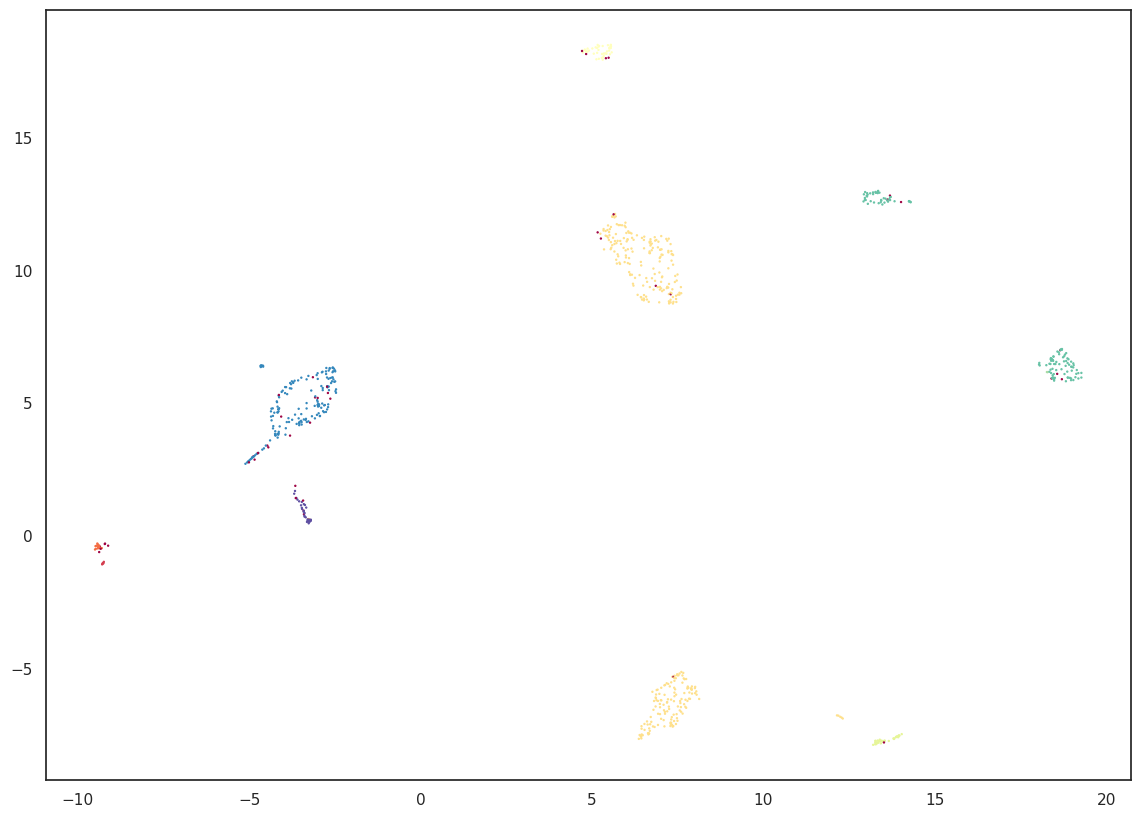

In [222]:
# perform analysis on training data
data = sc_preprocess(sc_test, 200)
labels_true = metadata_train["Celltype"]

test_hdbscan(data, labels_true, 10, plot=True, test=True)

0.3417087397893399

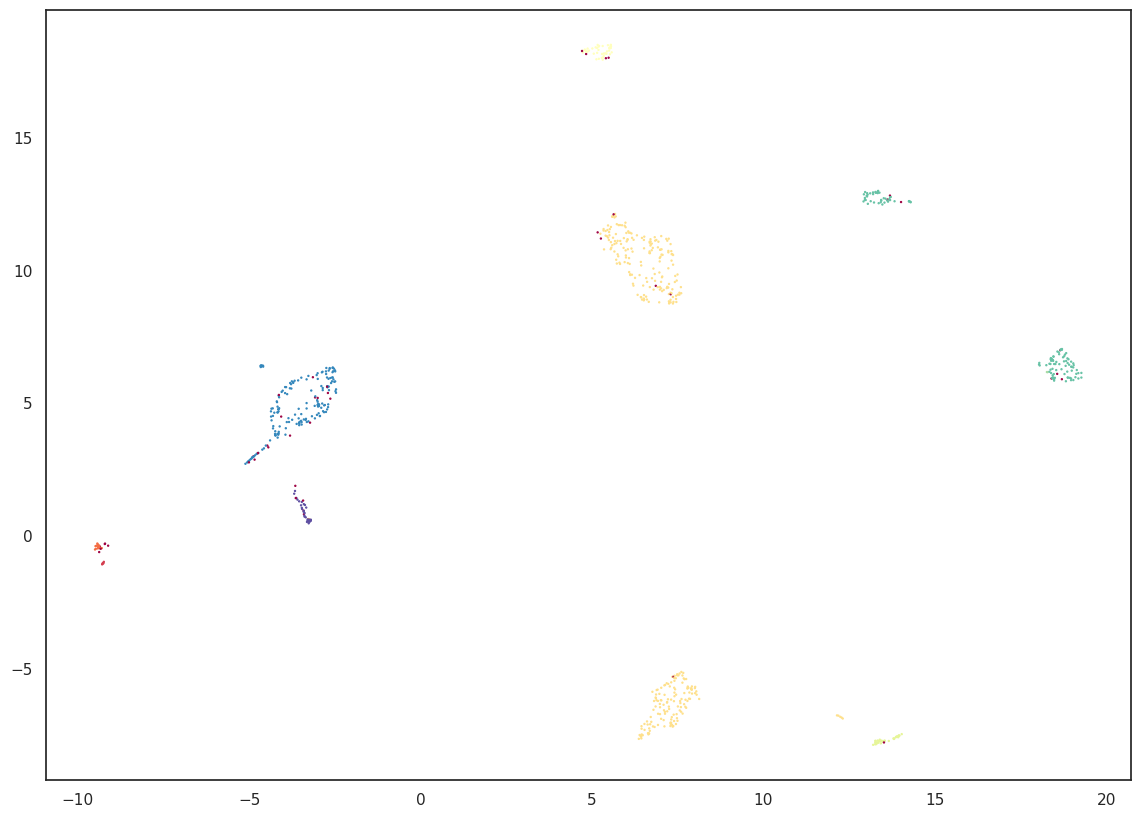

In [ ]:
# perform analysis on training data
data = sc_preprocess(sc_test, 200)
labels_true = metadata_train["Celltype"]

test_hdbscan(data, labels_true, 10, plot=True, test=True)

0.33882176148303633

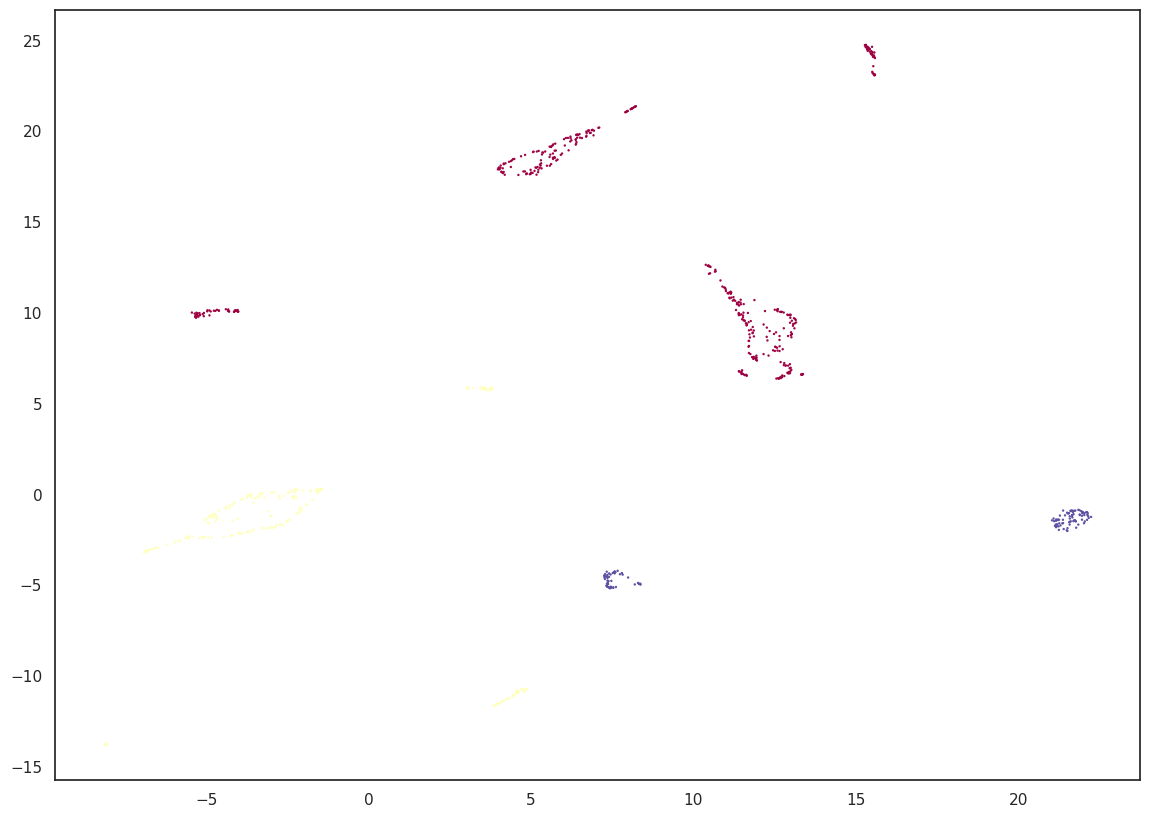

In [34]:
# perform analysis on training data
data = sc_preprocess(sc_test, 200)
labels_true = metadata_train["Celltype"]

test_kmeans_umap(data, labels_true, 3, 50, plot=True, test=True)

0.43233656782174246

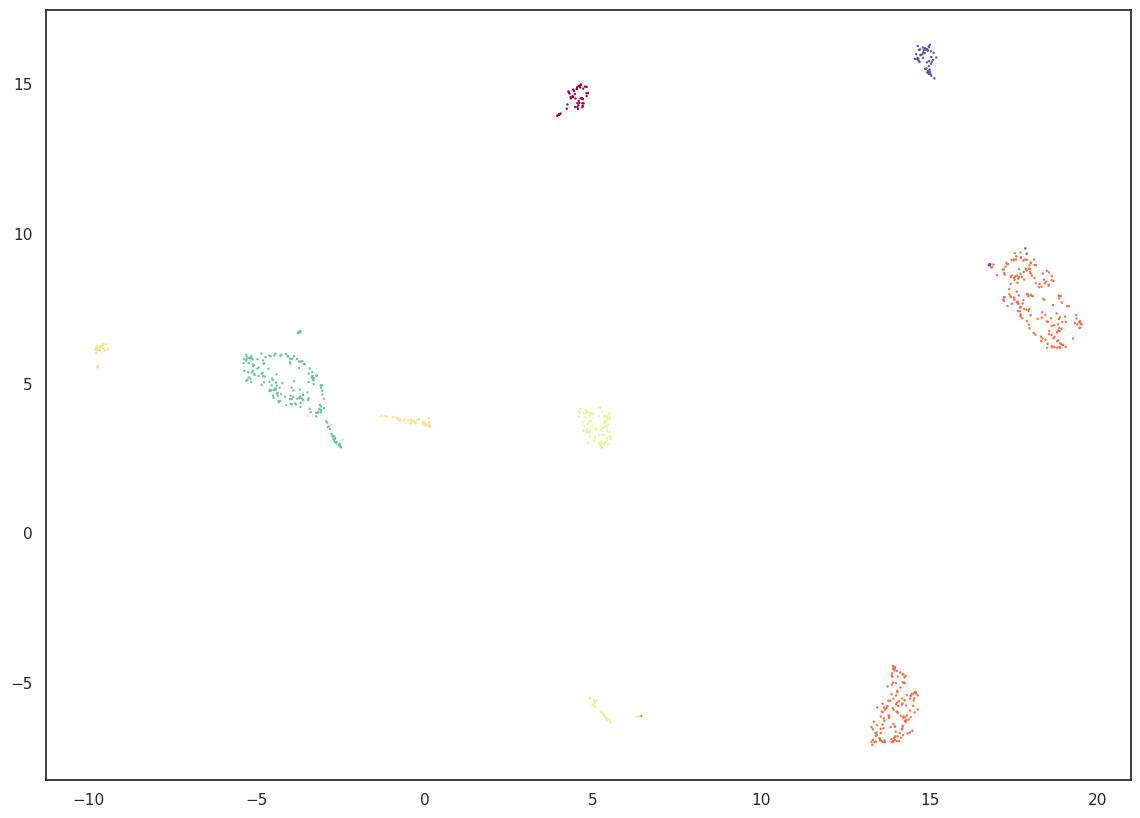

In [20]:
# perform analysis on training data
data = sc_preprocess(sc_test, 200)
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 6, plot=True, test=True)

In [18]:
# perform analysis on training data
data = pd.read_csv("ML4G_Project_2_Data/test_data/imputed_test_data_magic.csv", index_col=0)
#data = perform_batch_correction(metadata_test, data, ["Sample"])
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 5, plot=True, test=True)

FileNotFoundError: [Errno 2] No such file or directory: 'ML4G_Project_2_Data/imputed_data/imputed_test_data_magic.csv'

0.8802519019955989

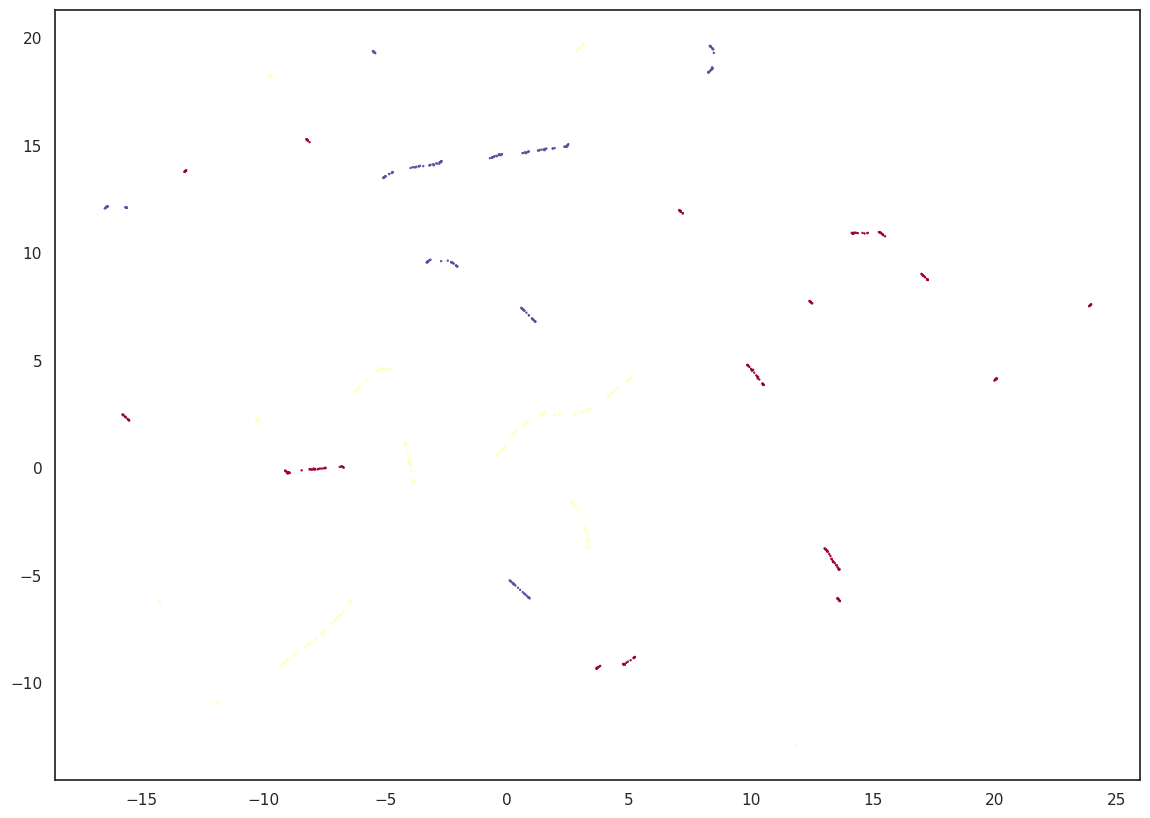

In [38]:
# perform analysis on training data
data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_test_data_magic_pp.csv", index_col=0)
#data = perform_batch_correction(metadata_test, data, ["Sample"])
labels_true = metadata_train["Celltype"]

test_kmeans_umap(data, labels_true, 5, 2, plot=True, test=True)

V-measure: 0.805
Adjusted Rand Index: 0.811
Silhouette Coefficient: 0.747
Overall Clustering Score: 0.7879184103295658


0.7879184103295658

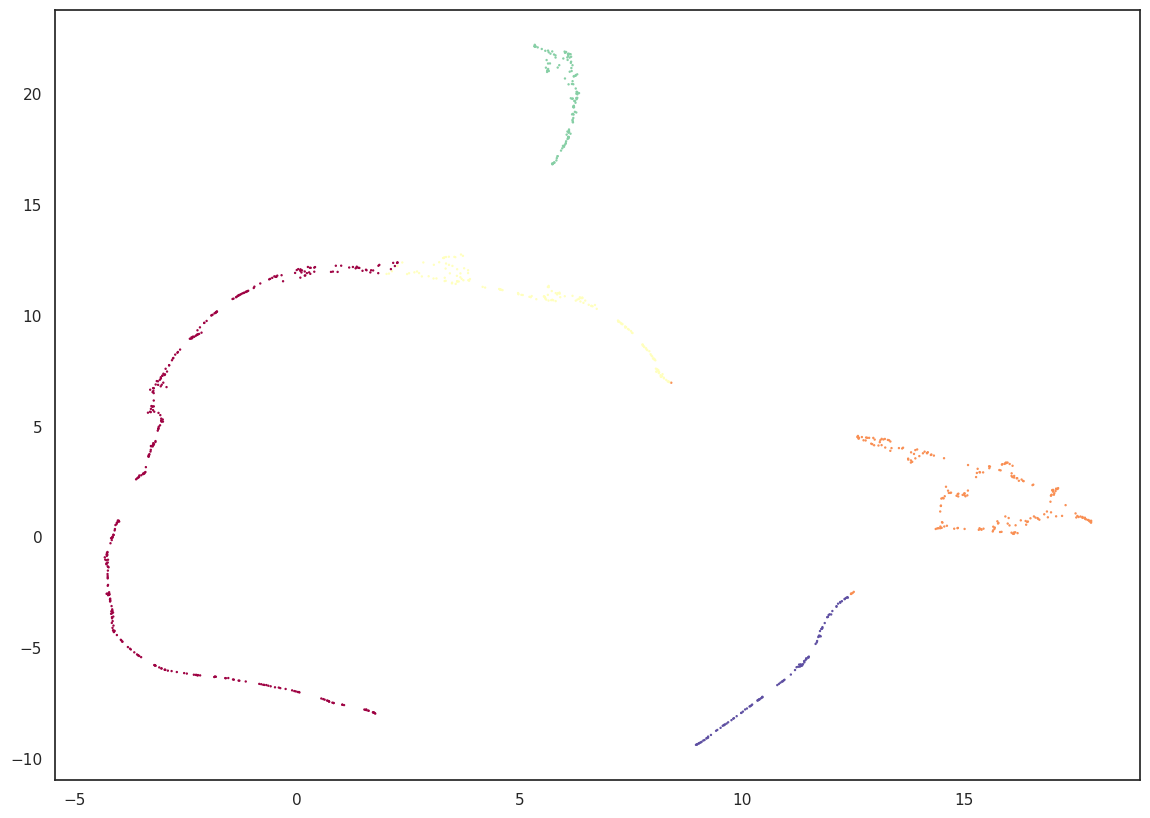

In [237]:
# Look at results for kmeans
data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_magic_pp.csv", index_col=0)
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 5)

V-measure: 0.847
Adjusted Rand Index: 0.874
Silhouette Coefficient: 0.419
Overall Clustering Score: 0.7134135815095266


0.7134135815095266

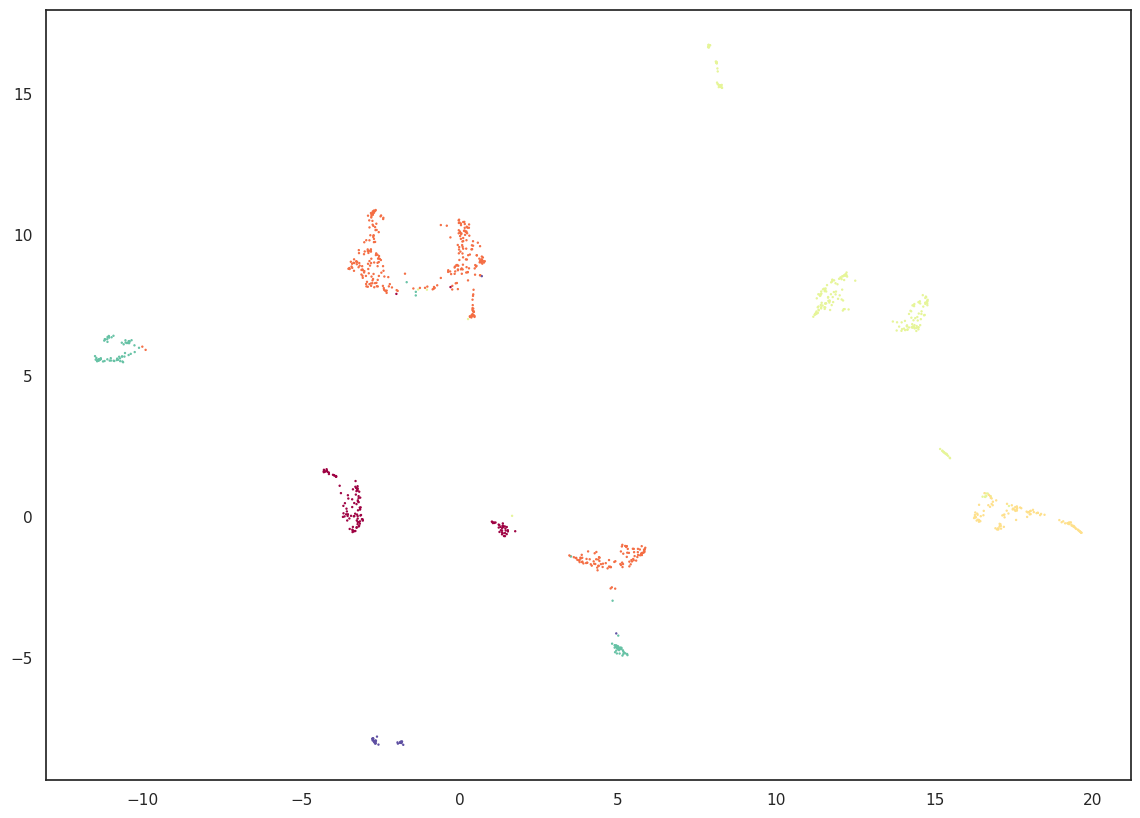

In [25]:
# Look at results for kmeans
data = sc_train_pp
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 6)

V-measure: 0.857
Adjusted Rand Index: 0.880
Silhouette Coefficient: 0.422
Overall Clustering Score: 0.7196116004464607


0.7196116004464607

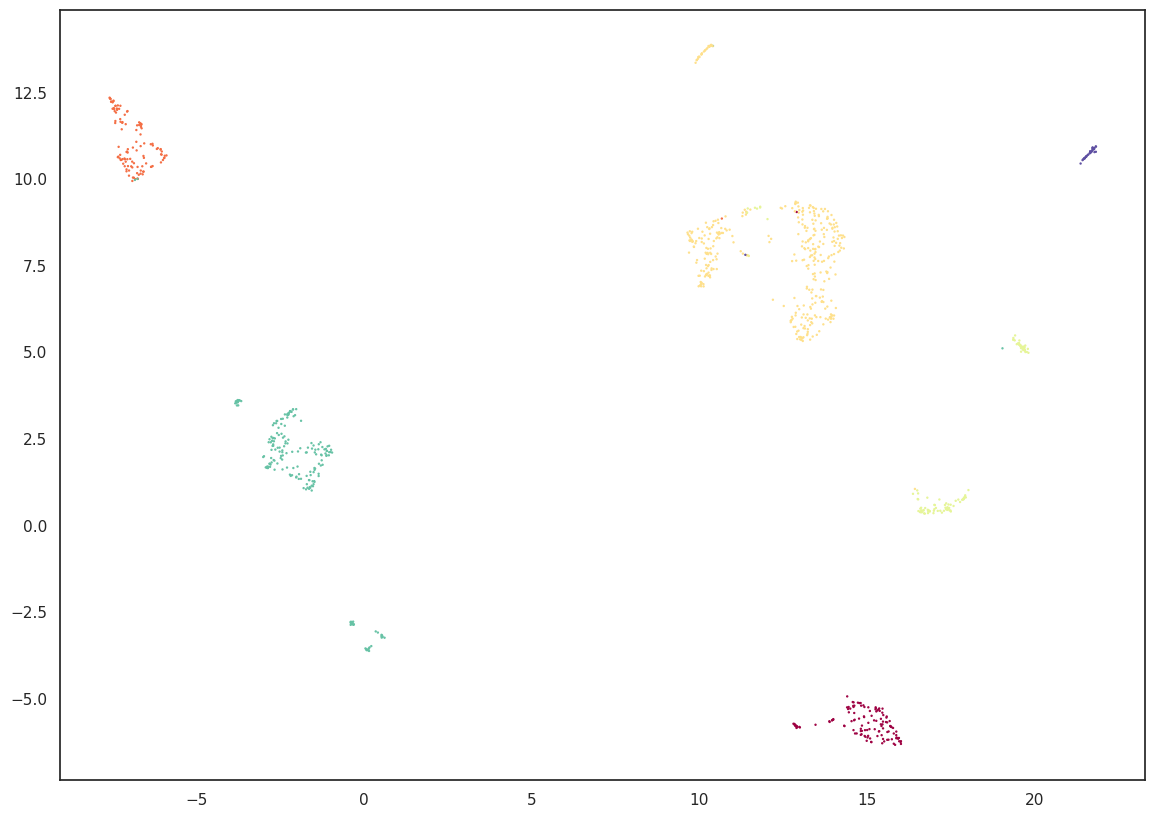

In [27]:
# Look at results for kmeans
data = sc_train_pp_bc
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 6)

In [33]:
# Look at results for kmeans
data = sc_train_pp
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 6)

UnboundLocalError: local variable 'lowd_data' referenced before assignment

V-measure: 0.833
Adjusted Rand Index: 0.861
Silhouette Coefficient: 0.418
Overall Clustering Score: 0.7039966797731843


0.7039966797731843

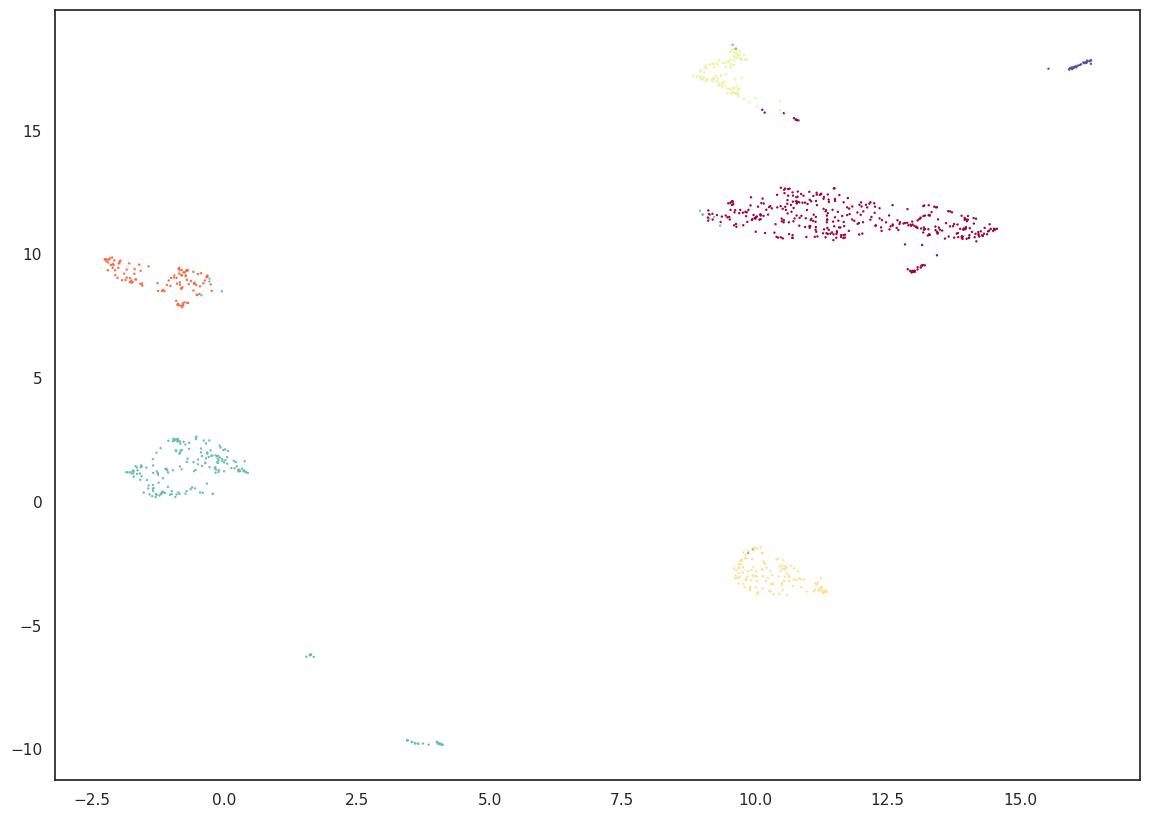

In [29]:
# Look at results for kmeans
data = sc_train_pp_bc
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 6)

In [209]:
# Look at results for kmeans
data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_magic_pp.csv", index_col=0)
labels_true = metadata_train["Celltype"]

test_hdbscan(data, labels_true, 4, plot=False)

V-measure: 0.670
Adjusted Rand Index: 0.558
Silhouette Coefficient: 0.708
Overall Clustering Score: 0.6454663671391212


0.6454663671391212

V-measure: 0.805
Adjusted Rand Index: 0.811
Silhouette Coefficient: 0.747
Overall Clustering Score: 0.7879184103295653


0.7879184103295653

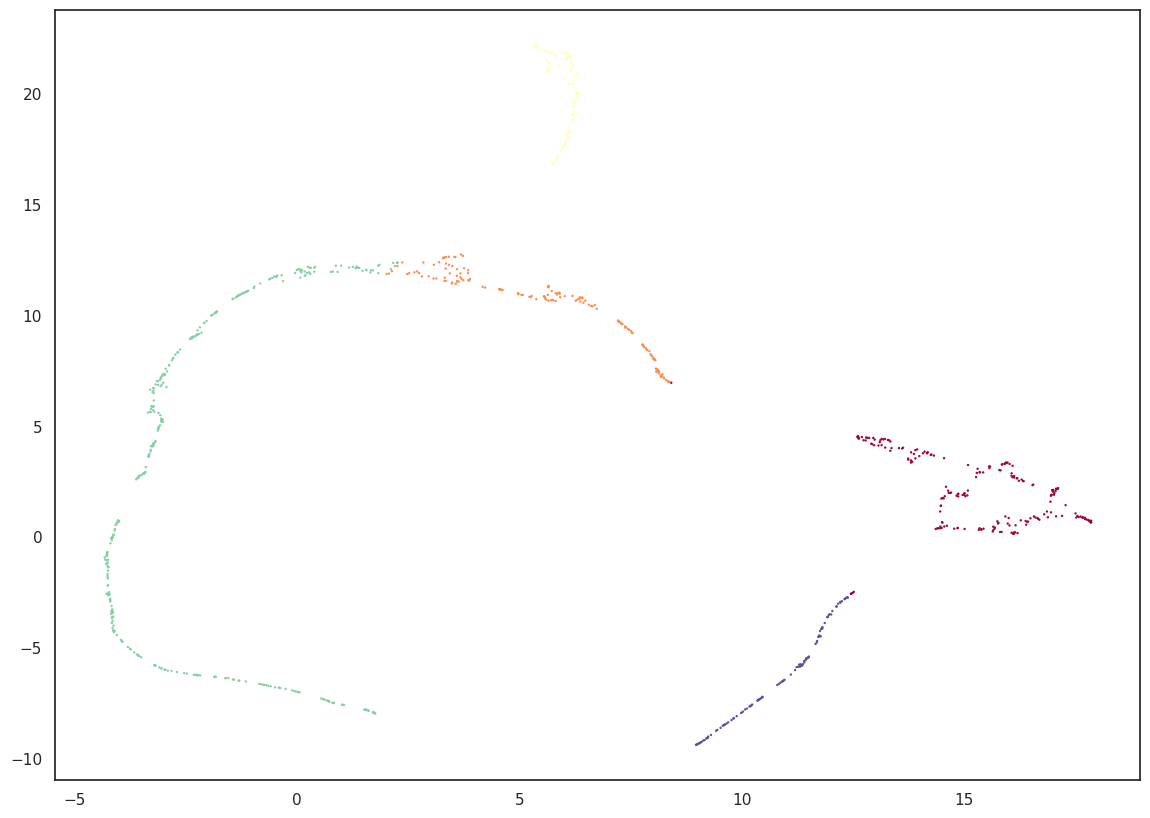

In [200]:
# Look at results for kmeans
data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_magic_pp.csv", index_col=0)
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 5)

V-measure: 0.796
Adjusted Rand Index: 0.755
Silhouette Coefficient: 0.042
Overall Clustering Score: 0.5308238173329254


0.2161597573836696

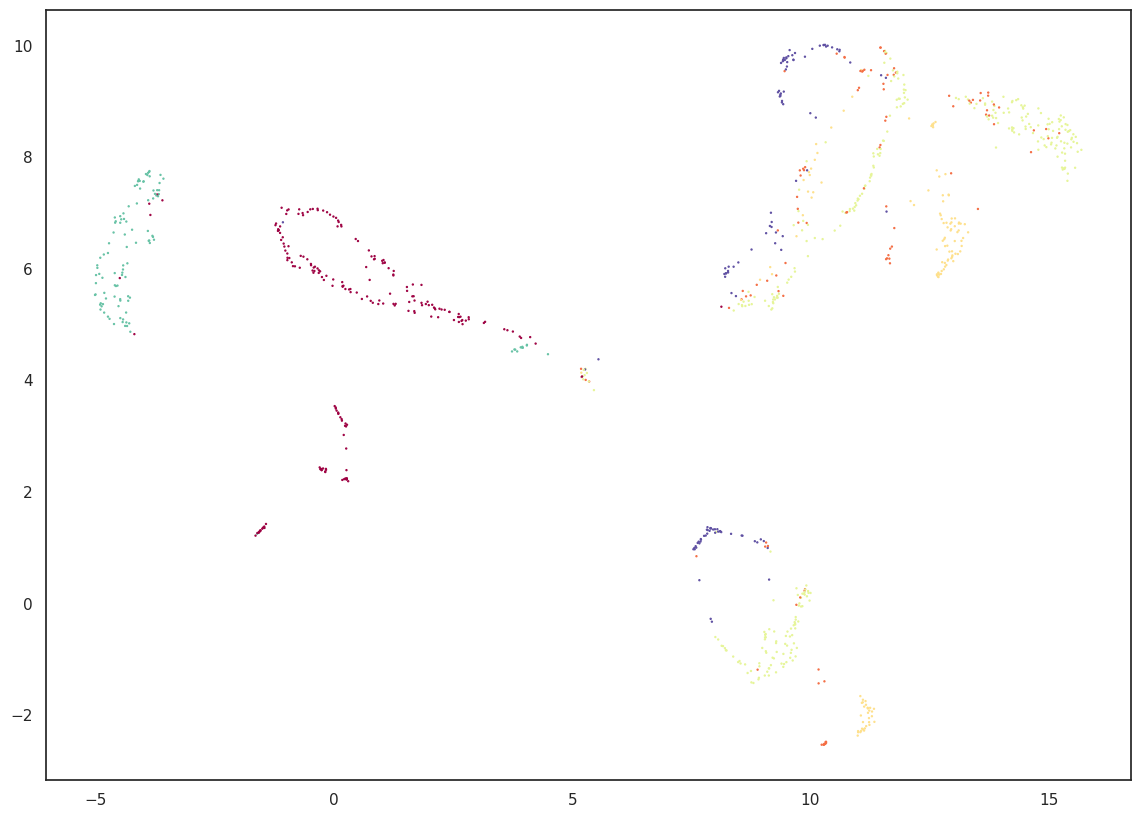

In [167]:
# Look at results for kmeans
from sklearn.cluster import KMeans

data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_scISR_log.csv", index_col=0).T
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 3)

V-measure: 0.162
Adjusted Rand Index: -0.042
Silhouette Coefficient: 0.569
Overall Clustering Score: 0.22954312171679128


0.22954312171679128

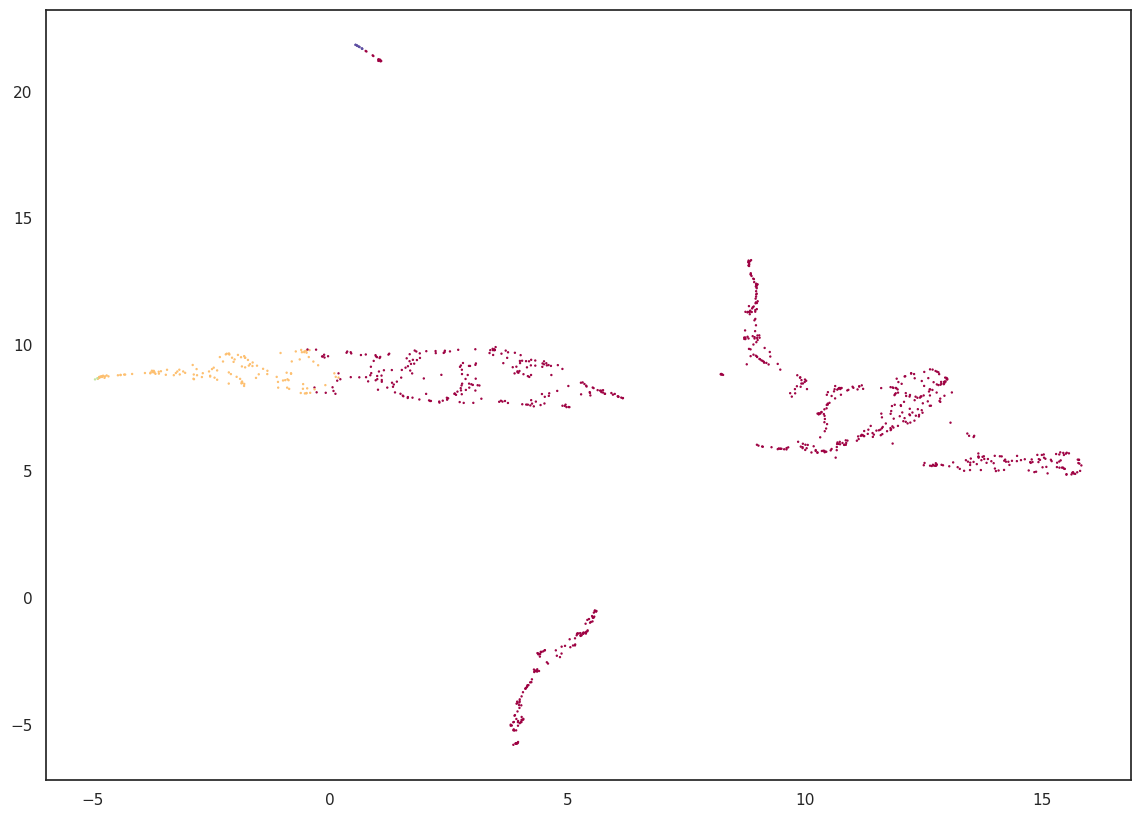

In [187]:
# Look at results for kmeans
from sklearn.cluster import KMeans

data = pd.read_csv("ML4G_Project_2_Data/train_data/pancreas_sc_train_pp_bc_disease.csv", index_col=0)
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 3)

V-measure: 0.796
Adjusted Rand Index: 0.755
Silhouette Coefficient: 0.042
Overall Clustering Score: 0.5307265279437465


0.2372274641190421

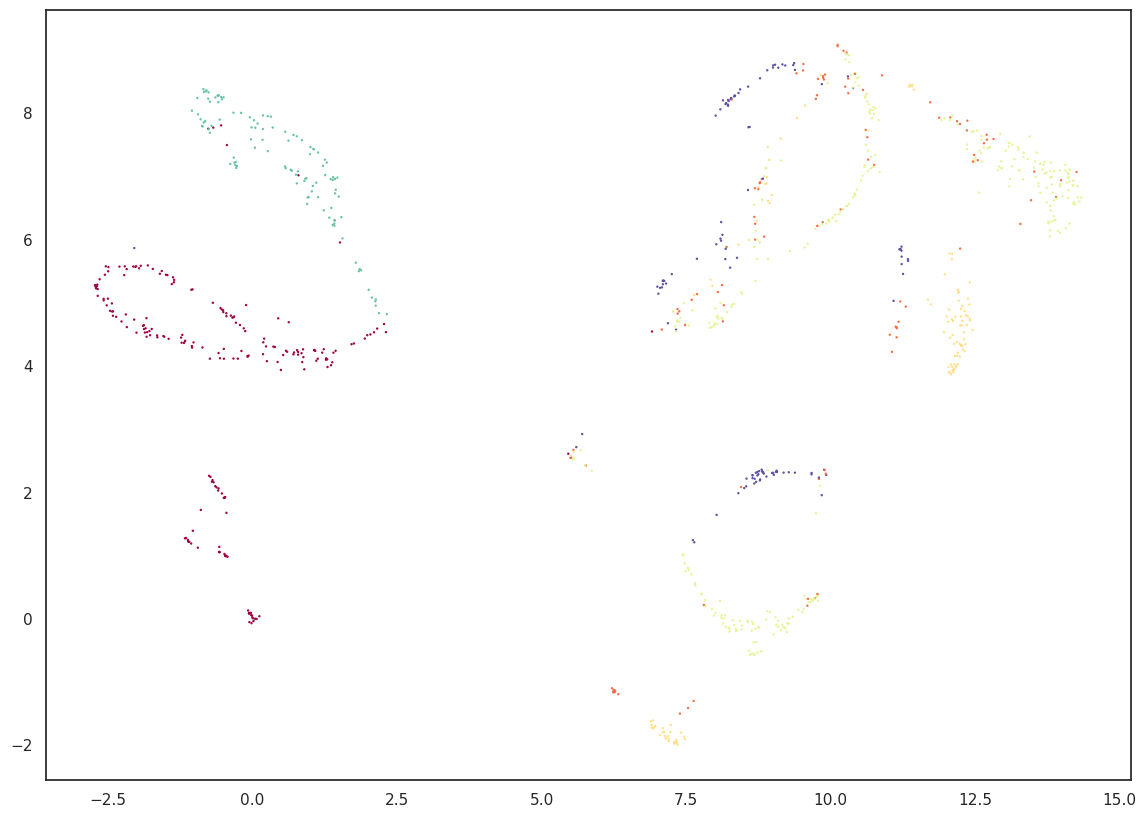

In [174]:
# Look at results for kmeans
from sklearn.cluster import KMeans

data = pd.read_csv("ML4G_Project_2_Data/imputed_data/imputed_data_scISR.csv", index_col=0).T
labels_true = metadata_train["Celltype"]

test_kmeans(data, labels_true, 5)

2023-04-22 22:53:19,973 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-04-22 22:53:22,111 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-22 22:53:22,117 - harmonypy - INFO - Iteration 1 of 20
2023-04-22 22:53:23,133 - harmonypy - INFO - Iteration 2 of 20
2023-04-22 22:53:24,156 - harmonypy - INFO - Iteration 3 of 20
2023-04-22 22:53:25,124 - harmonypy - INFO - Iteration 4 of 20
2023-04-22 22:53:26,007 - harmonypy - INFO - Iteration 5 of 20
2023-04-22 22:53:26,826 - harmonypy - INFO - Iteration 6 of 20
2023-04-22 22:53:27,685 - harmonypy - INFO - Iteration 7 of 20
2023-04-22 22:53:28,506 - harmonypy - INFO - Iteration 8 of 20
2023-04-22 22:53:29,383 - harmonypy - INFO - Iteration 9 of 20
2023-04-22 22:53:30,207 - harmonypy - INFO - Iteration 10 of 20
2023-04-22 22:53:31,036 - harmonypy - INFO - Iteration 11 of 20
2023-04-22 22:53:31,840 - harmonypy - INFO - Iteration 12 of 20
2023-04-22 22:53:32,667 - harmonypy - INFO - Iteration 13 of

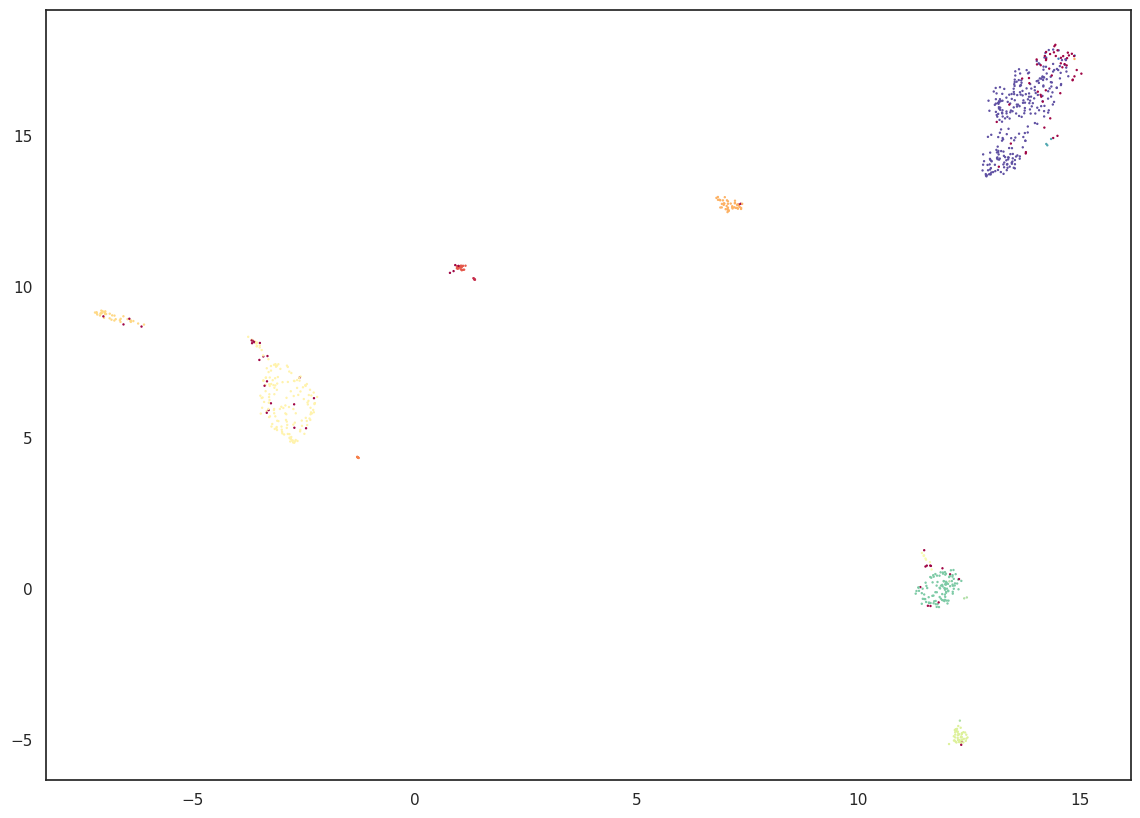

In [ ]:
# perform analysis on training data
sc_test_pp = sc_preprocess(sc_test, 200)
sc_test_pp_bc = perform_batch_correction(metadata_test, sc_test_pp, ["Disease"], max_iter=20)
hdbscan_labels = obtain_clusters_HDBSCAN(sc_test_pp_bc, 50, 6)
standard_embedding = umap.UMAP(random_state=42).fit_transform(sc_test_pp_bc)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=hdbscan_labels["HDBSCAN"], s=0.5, cmap='Spectral');